In [1]:
from math import exp, sqrt, cos, sin

import numba
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def calculate_pml_parameters(npml, ie, je, ke):
    """ Calculate and return the PML parameters """
    gi1 = np.zeros(ie)
    gi2 = np.ones(ie)
    gi3 = np.ones(ie)
    fi1 = np.zeros(ie)
    fi2 = np.ones(ie)
    fi3 = np.ones(ie)
    gj1 = np.zeros(je)
    gj2 = np.ones(je)
    gj3 = np.ones(je)
    fj1 = np.zeros(je)
    fj2 = np.ones(je)
    fj3 = np.ones(je)
    gk1 = np.zeros(ke)
    gk2 = np.ones(ke)
    gk3 = np.ones(ke)
    fk1 = np.zeros(ke)
    fk2 = np.ones(ke)
    fk3 = np.ones(ke)

    for n in range(npml):
        xxn = (npml - n) / npml
        xn = 0.33 * (xxn ** 3)
        fi1[n] = xn
        fi1[ie - n - 1] = xn
        gi2[n] = 1 / (1 + xn)
        gi2[ie - 1 - n] = 1 / (1 + xn)
        gi3[n] = (1 - xn) / (1 + xn)
        gi3[ie - 1 - n] = (1 - xn) / (1 + xn)
        
        fj1[n] = xn
        fj1[je - n - 1] = xn
        gj2[n] = 1 / (1 + xn)
        gj2[je - 1 - n] = 1 / (1 + xn)
        gj3[n] = (1 - xn) / (1 + xn)
        gj3[je - 1 - n] = (1 - xn) / (1 + xn)
        
        fk1[n] = xn
        fk1[ke - n - 1] = xn
        gk2[n] = 1 / (1 + xn)
        gk2[ke - 1 - n] = 1 / (1 + xn)
        gk3[n] = (1 - xn) / (1 + xn)
        gk3[ke - 1 - n] = (1 - xn) / (1 + xn)
        
        xxn = (npml - n - 0.5) / npml
        xn = 0.33 * (xxn ** 3)
        
        gi1[n] = xn
        gi1[ie - 1 - n] = xn
        fi2[n] = 1 / (1 + xn)
        fi2[ie - 1 - n] = 1 / (1 + xn)
        fi3[n] = (1 - xn) / (1 + xn)
        fi3[ie - 1 - n] = (1 - xn) / (1 + xn)

        
        gj1[n] = xn
        gj1[je - 1 - n] = xn
        fj2[n] = 1 / (1 + xn)
        fj2[je - 1 - n] = 1 / (1 + xn)
        fj3[n] = (1 - xn) / (1 + xn)
        fj3[je - 1 - n] = (1 - xn) / (1 + xn)
        
        gk1[n] = xn
        gk1[ke - 1 - n] = xn
        fk2[n] = 1 / (1 + xn)
        fk2[ke - 1 - n] = 1 / (1 + xn)
        fk3[n] = (1 - xn) / (1 + xn)
        fk3[ke - 1 - n] = (1 - xn) / (1 + xn)
   
    return gi1, gi2, gi3, fi1, fi2, fi3, gj1, gj2, gj3, fj1, fj2, fj3, gk1, gk2, gk3,fk1, fk2, fk3

In [3]:
@numba.jit(nopython=True)
def calculate_dx_field(ie, je, ke, dx, idx, hy, hz, gj3, gk3, gj2, gk2, gi1):
    """ Calculate the Dx Field """
    for i in range(1, ie):
        for j in range(1, je):
            for k in range(1, ke):
                curl_h = (hz[i, j, k] - hz[i, j - 1, k] - hy[i, j, k] + hy[i, j, k - 1])
                idx[i, j, k] = idx[i, j, k] + curl_h
                dx[i, j, k] = gj3[j] * gk3[k] * dx[i, j, k] + gj2[j] * gk2[k] * (0.5 * curl_h + gi1[i] * idx[i, j, k])

    return dx, idx

@numba.jit(nopython=True)
def calculate_dy_field(ie, je, ke, dy, idy, hx, hz, gi3, gk3, gi2, gk2, gj1):
    """ Calculate the Dy Field """
    for i in range(1, ie):
        for j in range(1, je):
            for k in range(1, ke):
                curl_h = (hx[i, j, k] - hx[i, j, k - 1] - hz[i, j, k] + hz[i - 1, j, k])
                idy[i, j, k] = idy[i, j, k] + curl_h
                dy[i, j, k] = gi3[i] * gk3[k] * dy[i, j, k] + gi2[i] * gk2[k] * (0.5 * curl_h + gj1[j] * idy[i, j, k])
    
    return dy, idy

@numba.jit(nopython=True)
def calculate_dz_field(ie, je, ke, dz, idz, hx, hy, gi3, gj3, gi2, gj2, gk1):
    """ Calculate the Dz Field """
    for i in range(1, ie):
        for j in range(1, je):
            for k in range(1, ke):
                curl_h = (hy[i, j, k] - hy[i - 1, j, k] - hx[i, j, k] + hx[i, j - 1, k])
                idz[i, j, k] = idz[i, j, k] + curl_h
                dz[i, j, k] = gi3[i] * gj3[j] * dz[i, j, k] + gi2[i] * gj2[j] * (0.5 * curl_h + gk1[k] * idz[i, j, k])
    
    return dz, idz

In [4]:
@numba.jit(nopython=True)
def calculate_inc_dy_field(ia, ib, ja, jb, ka, kb, dy, hx_inc):
    """ Calculate the incident Dy Field """
    for i in range(ia, ib + 1):
        for j in range(ja, jb + 1):
            dy[i, j, ka] = dy[i, j, ka] - 0.5 * hx_inc[j]
            dy[i, j, kb + 1] = dy[i, j, kb + 1] + 0.5 * hx_inc[j]
    return dy

@numba.jit(nopython=True)
def calculate_inc_dz_field(ia, ib, ja, jb, ka, kb, dz, hx_inc):
    """ Calculate the incident Dz Field"""
    for i in range(ia, ib + 1):
        for k in range(ka, kb + 1):
            dz[i, ja, k] = dz[i, ja, k] + 0.5 * hx_inc[ja - 1]
            dz[i, jb, k] = dz[i, jb, k] - 0.5 * hx_inc[jb]
    return dz

@numba.jit(nopython=True)
def calculate_e_fields(ie, je, ke, dx, dy, dz, gax, gay, gaz, gbx, gby, gbz, ex, ey, ez, ix, iy, iz):
    """ Calculate the E field from the D field"""
    for i in range(0, ie):
        for j in range(0, je):
            for k in range(0, ke):
                ex[i, j, k] = gax[i, j, k] * (dx[i, j, k] - ix[i, j, k])
                ix[i, j, k] = ix[i, j, k] + gbx[i, j, k] * ex[i, j, k]
                ey[i, j, k] = gay[i, j, k] * (dy[i, j, k] - iy[i, j, k])
                iy[i, j, k] = iy[i, j, k] + gby[i, j, k] * ey[i, j, k]
                ez[i, j, k] = gaz[i, j, k] * (dz[i, j, k] - iz[i, j, k])
                iz[i, j, k] = iz[i, j, k] + gbz[i, j, k] * ez[i, j, k]
    return ex, ey, ez, ix, iy, iz

In [5]:
@numba.jit(nopython=True)
def calculate_fourier_transform_ex(ie, je, number_of_frequencies, real_pt, imag_pt, ez, arg, time_step, kc):
    """ Calculate the Fourier transform of Ex"""
    for i in range(0, ie):
        for j in range(0, je):
            for m in range(0, number_of_frequencies):
                real_pt[m, i, j] = real_pt[m, i, j] + cos(arg[m] * time_step) * ez[i, j, kc]
                imag_pt[m, i, j] = imag_pt[m, i, j] - sin(arg[m] * time_step) * ez[i, j, kc]
    
    return real_pt, imag_pt

@numba.jit(nopython=True)
def calculate_hx_field(ie, je, ke, hx, ihx, ey, ez, fi1, fj2, fk2, fj3, fk3):
    """ Calculate the Hx field"""
    for i in range(0, ie):
        for j in range(0, je - 1):
            for k in range(0, ke - 1):
                curl_e = (ey[i, j, k + 1] - ey[i, j, k] -
                ez[i, j + 1, k] + ez[i, j, k])
                ihx[i, j, k] = ihx[i, j, k] + curl_e
                hx[i, j, k] = fj3[j] * fk3[k] * hx[i, j, k] + fj2[j] * fk2[k] * 0.5 * (curl_e + fi1[i] * ihx[i, j, k])
    
    return hx, ihx

@numba.jit(nopython=True)
def calculate_hy_field(ie, je, ke, hy, ihy, ex, ez, fj1, fi2, fk2, fi3, fk3):
    """ Calculate the Hy field"""
    for i in range(0, ie - 1):
        for j in range(0, je):
            for k in range(0, ke - 1):
                curl_e = (ez[i + 1, j, k] - ez[i, j, k] -
                ex[i, j, k + 1] + ex[i, j, k])
                ihy[i, j, k] = ihy[i, j, k] + curl_e
                hy[i, j, k] = fi3[i] * fk3[k] * hy[i, j, k] + fi2[i] * fk2[k] * 0.5 * (curl_e + fj1[j] * ihy[i, j, k])
    
    return hy, ihy

@numba.jit(nopython=True)
def calculate_hz_field(ie, je, ke, hz, ihz, ex, ey, fk1, fi2, fj2, fi3, fj3):
    """ Calculate the Hz field"""
    for i in range(0, ie - 1):
        for j in range(0, je - 1):
            for k in range(0, ke):
                curl_e = (ex[i, j + 1, k] - ex[i, j, k] -
                ey[i + 1, j, k] + ey[i, j, k])
                ihz[i, j, k] = ihz[i, j, k] + curl_e
                hz[i, j, k] = fi3[i] * fj3[j] * hz[i, j, k] + fi2[i] * fj2[j] * 0.5 * (curl_e + fk1[k] * ihz[i, j, k])
    
    return hz, ihz

@numba.jit(nopython=True)
def calculate_hx_inc(je, hx_inc, ez_inc):
    """ Calculate incident Hx field"""
    for j in range(0, je - 1):
        hx_inc[j] = hx_inc[j] + 0.5 * (ez_inc[j] - ez_inc[j + 1])

    return hx_inc
@numba.jit(nopython=True)
def calculate_hx_with_incident_field(ia, ib, ja, jb, ka, kb, hx, ez_inc):
    """ Calculate Hx with incident ez"""
    for i in range(ia, ib + 1):
        for k in range(ka, kb + 1):
            hx[i, ja - 1, k] = hx[i, ja - 1, k] + 0.5 * ez_inc[ja]
            hx[i, jb, k] = hx[i, jb, k] - 0.5 * ez_inc[jb]
    
    return hx

@numba.jit(nopython=True)
def calculate_hy_with_incident_field(ia, ib, ja, jb, ka, kb, hy, ez_inc):
    """ Calculate Hy with incident ez"""
    for j in range(ja, jb + 1):
        for k in range(ka, kb + 1):
            hy[ia - 1, j, k] = hy[ia - 1, j, k] - 0.5 * ez_inc[j]
            hy[ib, j, k] = hy[ib, j, k] + 0.5 * ez_inc[j]
    
    return hy

In [6]:
ie = 40
je = 40
ke = 40
ic = int(ie / 2)
jc = int(je / 2)
kc = int(ke / 2)
ia = 7
ja = 7
ka = 7
ib = ie - ia - 1
jb = je - ja - 1
kb = ke - ka - 1

ex = np.zeros((ie, je, ke))
ey = np.zeros((ie, je, ke))
ez = np.zeros((ie, je, ke))
ix = np.zeros((ie, je, ke))
iy = np.zeros((ie, je, ke))
iz = np.zeros((ie, je, ke))
dx = np.zeros((ie, je, ke))
dy = np.zeros((ie, je, ke))
dz = np.zeros((ie, je, ke))
idx = np.zeros((ie, je, ke))
idy = np.zeros((ie, je, ke))
idz = np.zeros((ie, je, ke))
hx = np.zeros((ie, je, ke))
hy = np.zeros((ie, je, ke))
hz = np.zeros((ie, je, ke))
ihx = np.zeros((ie, je, ke))
ihy = np.zeros((ie, je, ke))
ihz = np.zeros((ie, je, ke))

gax = np.ones((ie, je, ke))
gay = np.ones((ie, je, ke))
gaz = np.ones((ie, je, ke))
gbx = np.zeros((ie, je, ke))
gby = np.zeros((ie, je, ke))
gbz = np.zeros((ie, je, ke))
hx_inc = np.zeros(je)
ez_inc = np.zeros(je)

ddx = 0.01 # Cell size
dt = ddx / 6e8 # Time step size
epsz = 8.854e-12

number_of_frequencies = 3
freq = np.array((50e6, 200e6, 500e6))
arg = 2 * np.pi * freq * dt
real_in = np.zeros(number_of_frequencies)
imag_in = np.zeros(number_of_frequencies)
real_pt = np.zeros((number_of_frequencies, ie, je, ke))
imag_pt = np.zeros((number_of_frequencies, ie, je, ke))
amp = np.zeros((number_of_frequencies, je))

# Specify the dielectric sphere
epsilon = np.ones(2)
sigma = np.zeros(2)
epsilon[1] = 30
sigma[1] = 0.3
radius = 10

for i in range(ia, ib + 1):
    for j in range(ja, jb + 1):
        for k in range(ka, kb + 1):
            eps = epsilon[0]
            cond = sigma[0]
            xdist = ic - i - 0.5
            ydist = jc - j
            zdist = kc - k
            dist = sqrt(xdist ** 2 + ydist ** 2 + zdist ** 2)
            if dist <= radius:
                eps = epsilon[1]
                cond = sigma[1]
            gax[i, j, k] = 1 / (eps + (cond * dt / epsz))
            gbx[i, j, k] = cond * dt / epsz

for i in range(ia, ib + 1):
    for j in range(ja, jb + 1):
        for k in range(ka, kb + 1):
            eps = epsilon[0]
            cond = sigma[0]
            xdist = ic - i
            ydist = jc - j - 0.5
            zdist = kc - k
            dist = sqrt(xdist ** 2 + ydist ** 2 + zdist ** 2)
            if dist <= radius:
                eps = epsilon[1]
                cond = sigma[1]
            gay[i, j, k] = 1 / (eps + (cond * dt / epsz))
            gby[i, j, k] = cond * dt / epsz

for i in range(ia, ib + 1):
    for j in range(ja, jb + 1):
        for k in range(ka, kb + 1):
            eps = epsilon[0]
            cond = sigma[0]
            xdist = ic - i
            ydist = jc - j
            zdist = kc - k - 0.5
            dist = sqrt(xdist ** 2 + ydist ** 2 + zdist ** 2)
            if dist <= radius:
                eps = epsilon[1]
                cond = sigma[1]
            gaz[i, j, k] = 1 / (eps + (cond * dt / epsz))
            gbz[i, j, k] = cond * dt / epsz

# Pulse Parameters
t0 = 20
spread = 8

# Calculate the PML parameters
npml = 8
gi1, gi2, gi3, fi1, fi2, fi3, gj1, gj2, gj3, fj1, fj2, fj3, \
gk1, gk2, gk3, fk1, fk2, fk3 = calculate_pml_parameters(npml, ie, je, ke)

boundary_low = [0, 0]
boundary_high = [0, 0]

nsteps = 500

In [7]:
# Main FDTD Loop
for time_step in range(1, nsteps + 1):

    # Calculate the incident buffer
    for j in range(1, je - 1):
        ez_inc[j] = ez_inc[j] + 0.5 * (hx_inc[j - 1] - hx_inc[j])
    # Fourier transform of the incident field
    for m in range(number_of_frequencies):
        real_in[m] = real_in[m] + cos(arg[m] * time_step) * ez_inc[ja - 1]
        imag_in[m] = imag_in[m] - sin(arg[m] * time_step) * ez_inc[ja - 1]

    # Absorbing Boundary Conditions
    ez_inc[0] = boundary_low.pop(0)
    boundary_low.append(ez_inc[1])
    ez_inc[je - 1] = boundary_high.pop(0)
    boundary_high.append(ez_inc[je - 2])

    # Calculate the D Fields
    dx, idx = calculate_dx_field(ie, je, ke, dx, idx, hy, hz, gj3, gk3, gj2, gk2, gi1)
    dy, idy = calculate_dy_field(ie, je, ke, dy, idy, hx, hz, gi3, gk3, gi2, gk2, gj1)
    dz, idz = calculate_dz_field(ie, je, ke, dz, idz, hx, hy, gi3, gj3, gi2, gj2, gk1)

    # Add the source at the gap
    pulse = exp(-0.5 * ((t0 - time_step) / spread) ** 2)
    ez_inc[3] = pulse
    
    dy = calculate_inc_dy_field(ia, ib, ja, jb, ka, kb, dy, hx_inc)
    dz = calculate_inc_dz_field(ia, ib, ja, jb, ka, kb, dz, hx_inc)

    # Calculate the E field from the D field
    ex, ey, ez, ix, iy, iz = calculate_e_fields(ie, je, ke, dx, dy, dz, gax, gay, gaz, gbx, gby, gbz, ex, ey, ez, ix, iy, iz)

    # Calculate the Fourier transform of Ex
    real_pt, imag_pt = calculate_fourier_transform_ex(ie, je, number_of_frequencies, real_pt, imag_pt, ez, arg, time_step, kc)

    # Calculate the H fields
    hx_inc = calculate_hx_inc(je, hx_inc, ez_inc)
    hx, ihx = calculate_hx_field(ie, je, ke, hx, ihx, ey, ez, fi1, fj2, fk2, fj3, fk3)
    hx = calculate_hx_with_incident_field(ia, ib, ja, jb, ka, kb, hx, ez_inc)
    hy, ihy = calculate_hy_field(ie, je, ke, hy, ihy, ex, ez, fj1, fi2, fk2, fi3, fk3)
    hy = calculate_hy_with_incident_field(ia, ib, ja, jb, ka, kb, hy, ez_inc)
    hz, ihz = calculate_hz_field(ie, je, ke, hz, ihz, ex, ey, fk1, fi2, fj2, fi3, fj3)

# Calculate the Fourier amplitude of the incident pulse
amp_in = np.sqrt(real_in ** 2 + imag_in ** 2)
    
# Calculate the Fourier amplitude of the total field
for m in range(number_of_frequencies):
    for j in range(ja, jb + 1):
        if gaz[ic, j, kc] < 1:
            amp[m, j] = 1 / (amp_in[m]) * sqrt(real_pt[m, ic, j, kc] ** 2 + imag_pt[m, ic, j, kc] ** 2)

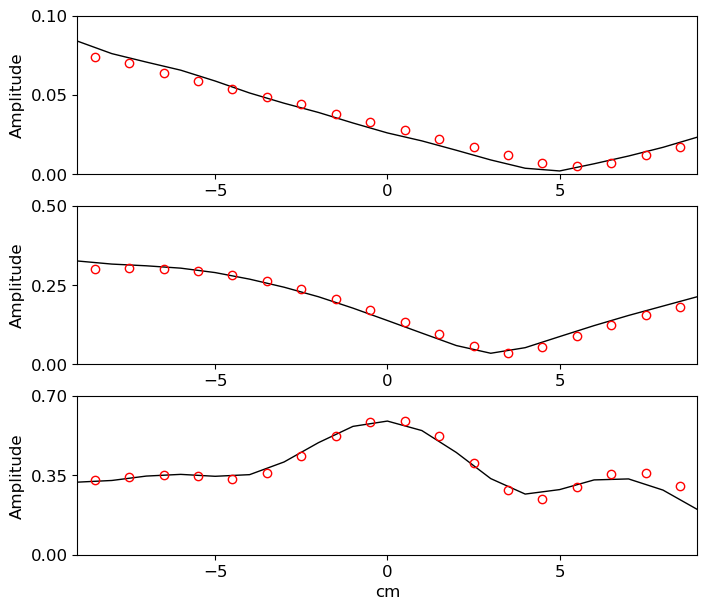

In [8]:
# Plot Fig. 4.7
plt.rcParams['font.size'] = 12
plt.rcParams['grid.color'] = 'gray'
plt.rcParams['grid.linestyle'] = 'dotted'
fig = plt.figure(figsize=(8, 7))
X, Y = np.meshgrid(range(je), range(ie))
compare_array = np.arange(-8.5, 10.5, step=1)
x_array = np.arange(-20, 20, step=1)

# The data here was generated with the 3D Bessel function expansion program
compare_amp = np.array([[0.074, 0.070, 0.064, 0.059, 0.054, 0.049, 0.044,
                         0.038, 0.033, 0.028, 0.022, 0.017, 0.012, 0.007,
                         0.005, 0.007, 0.012, 0.017, 0.022],
                        [0.302, 0.303, 0.301, 0.294, 0.281, 0.263, 0.238,
                         0.208, 0.173, 0.135, 0.095, 0.057, 0.036, 0.056,
                         0.091, 0.126, 0.156, 0.182, 0.202],
                        [0.329, 0.344, 0.353, 0.346, 0.336, 0.361, 0.436,
                         0.526, 0.587, 0.589, 0.524, 0.407, 0.285, 0.244,
                         0.300, 0.357, 0.360, 0.304, 0.208]])

def plot_amp(ax, data, compare, freq, scale):
    """Plot the Fourier transform amplitude at a specific frequency"""
    ax.plot(x_array, data, color='k', linewidth=1)
    ax.plot(compare_array, compare, 'ro', mfc='none', linewidth=1)
    plt.xlabel('cm')
    plt.ylabel('Amplitude')
    plt.xticks(np.arange(-5, 10, step=5))
    plt.xlim(-9, 9)
    plt.yticks(np.arange(0, 1, step=scale / 2))
    plt.ylim(0, scale)
    #ax.text(20, 0.6, '{} MHz'.format(int(freq / 1e6)), horizontalalignment='center')

# Plot the results of the Fourier transform at each of the frequencies
scale = np.array((0.1, 0.5, 0.7))
for m in range(number_of_frequencies):
    ax = fig.add_subplot(3, 1, m + 1)
    plot_amp(ax, amp[m, :], compare_amp[m], freq[m], scale[m])

#plt.tight_layout()
plt.show();

1. Field Component Snapshots:


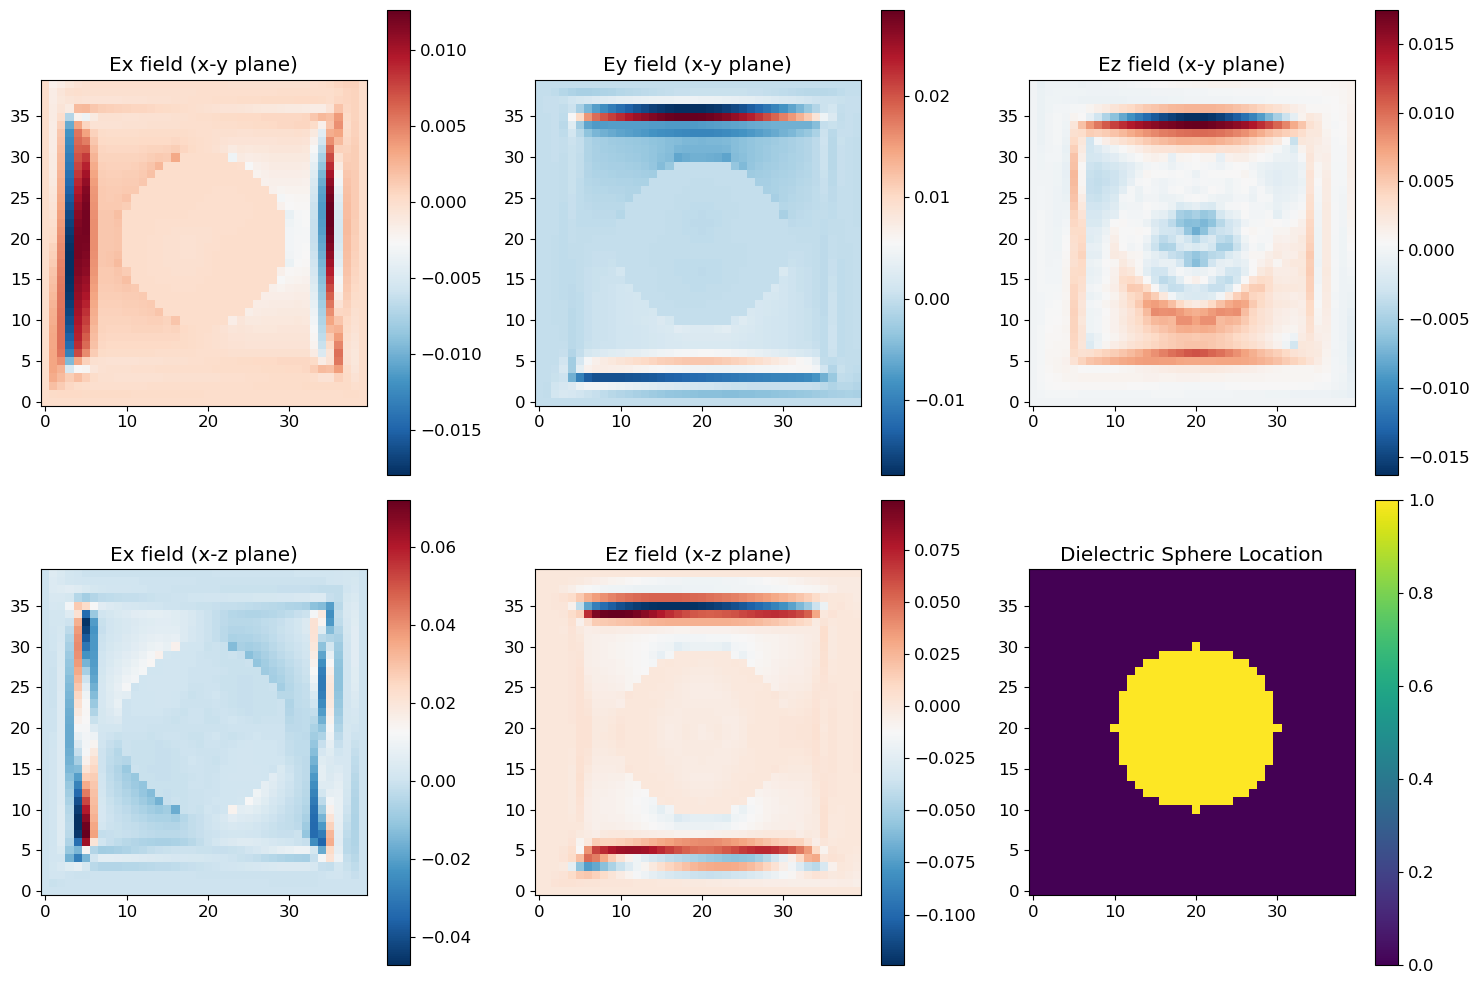

2. Field Components Along Lines:


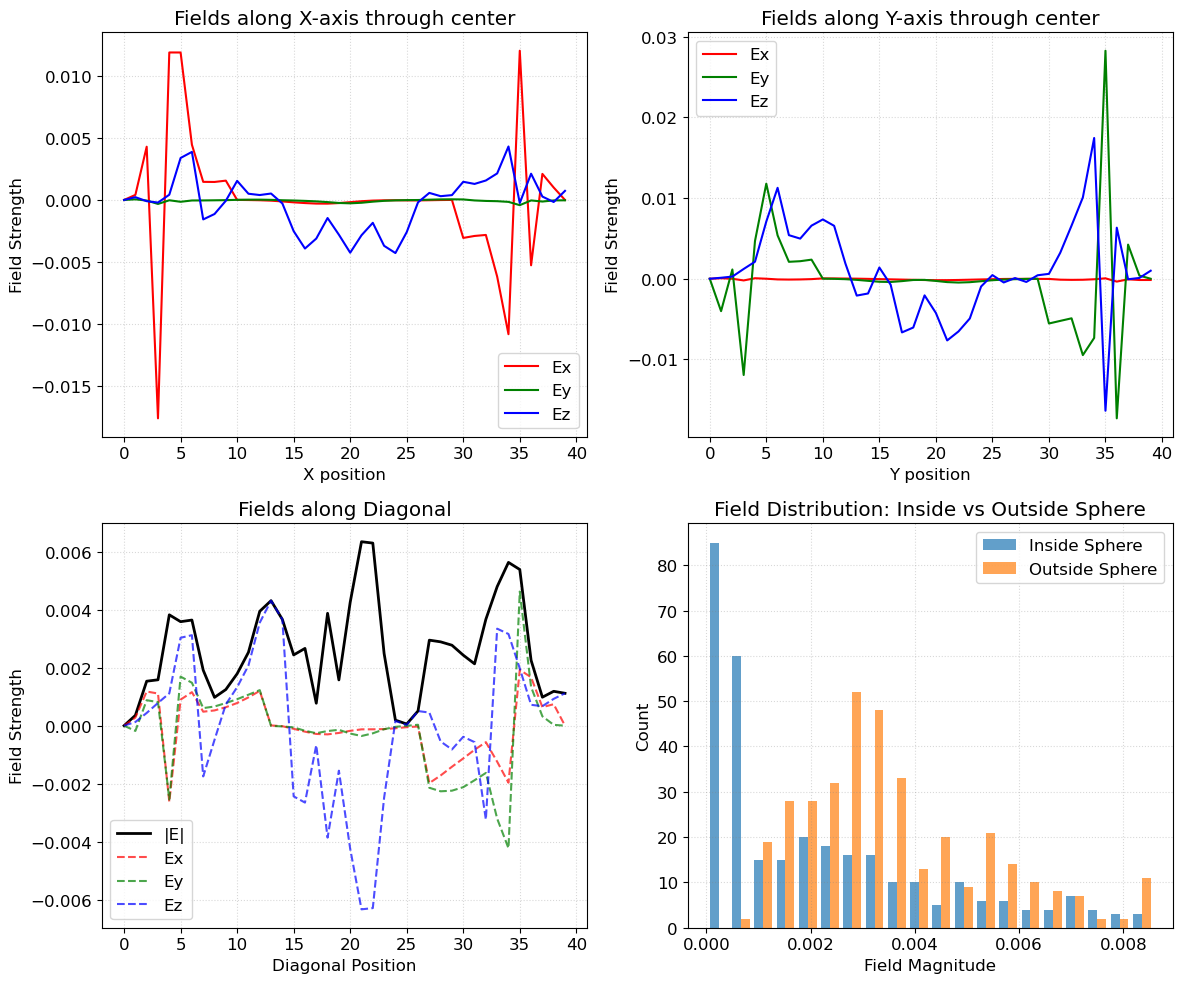

3. Frequency Domain Analysis:


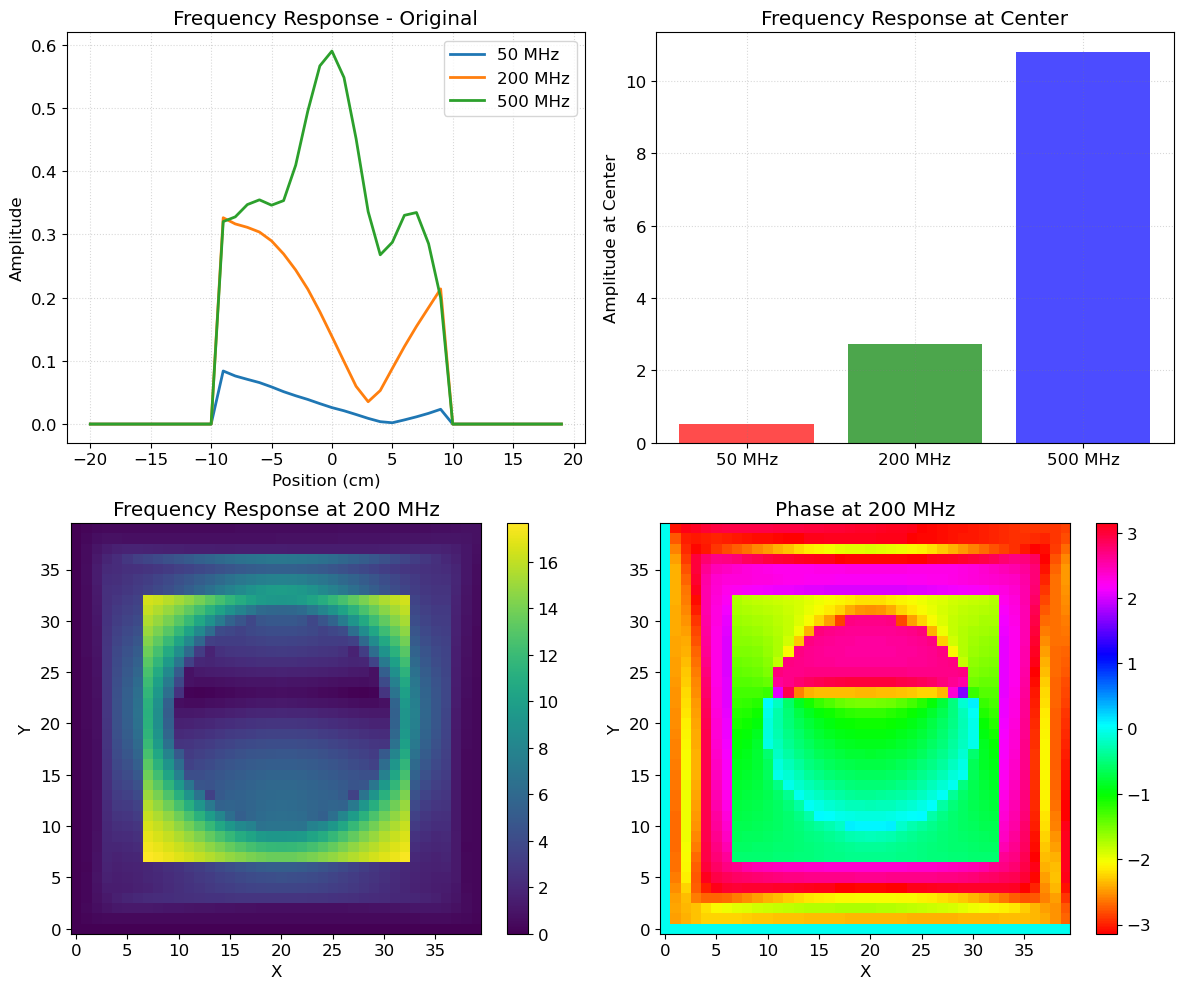

4. Comparative Analysis:


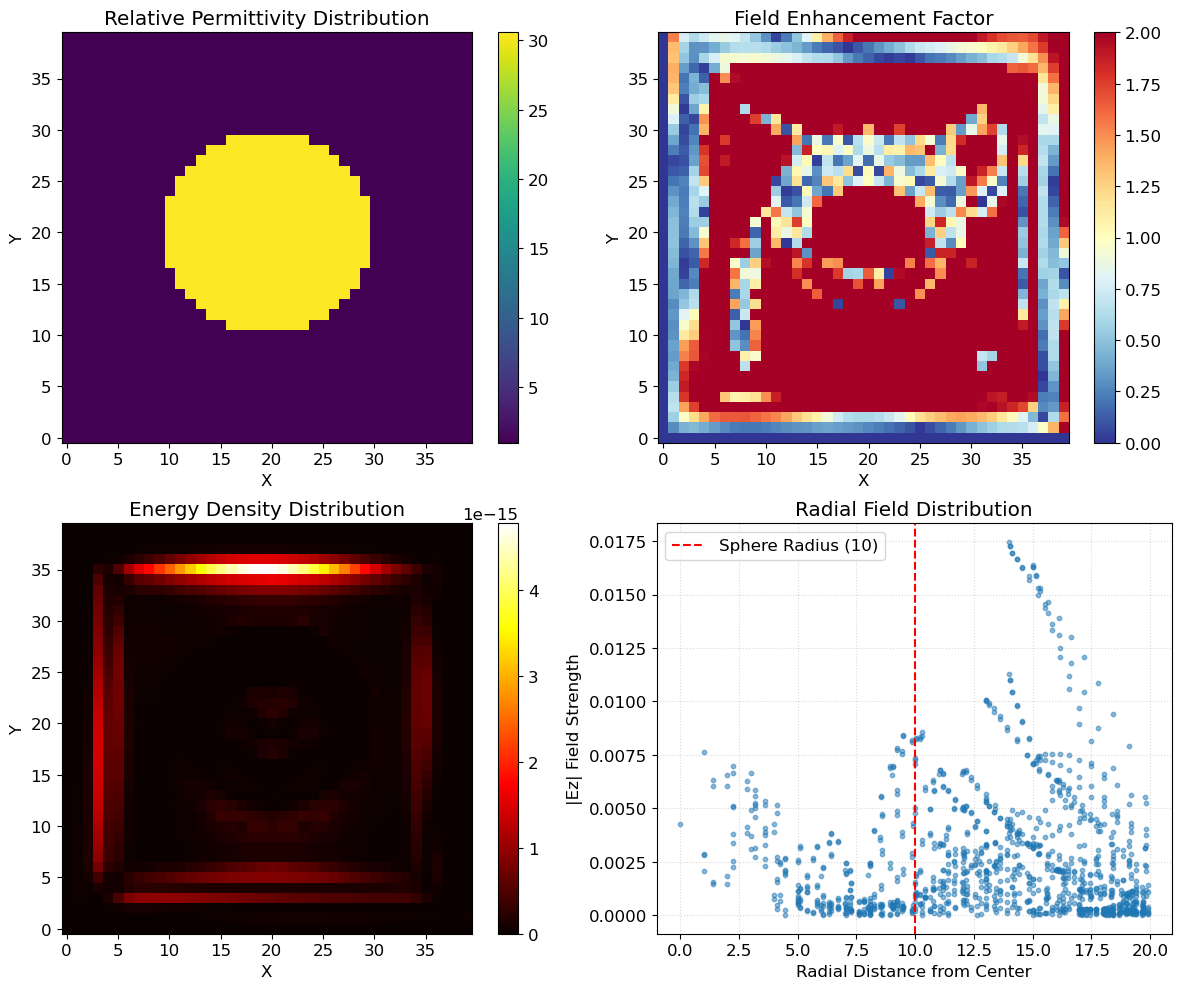

5. Animation Frames (Static):


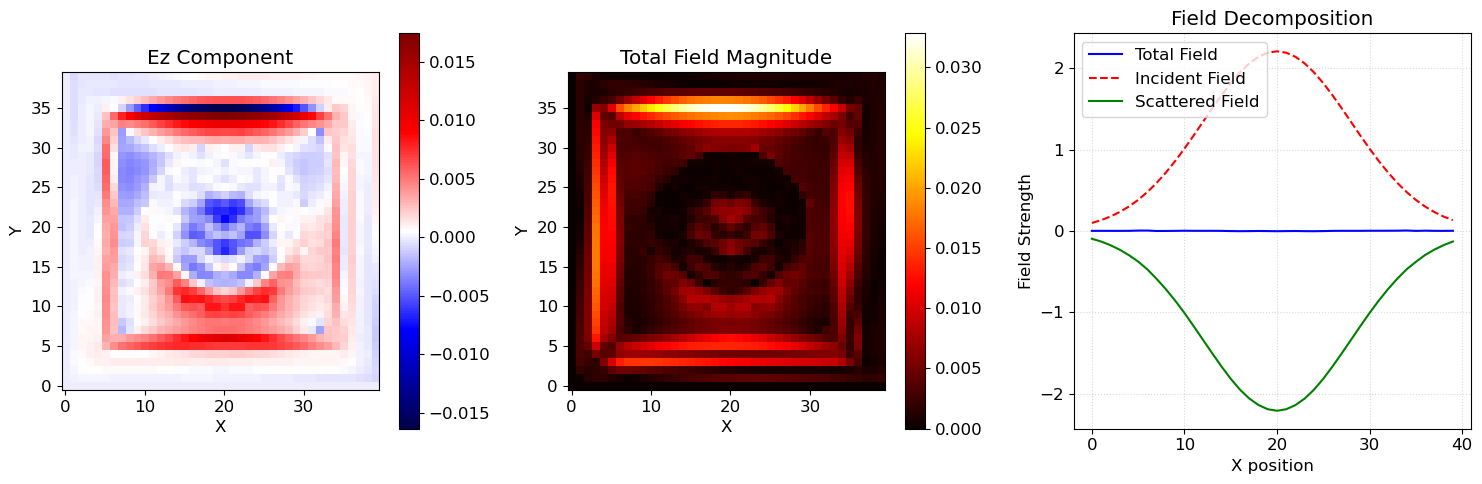

6. 3D Field Volume (may take a moment):


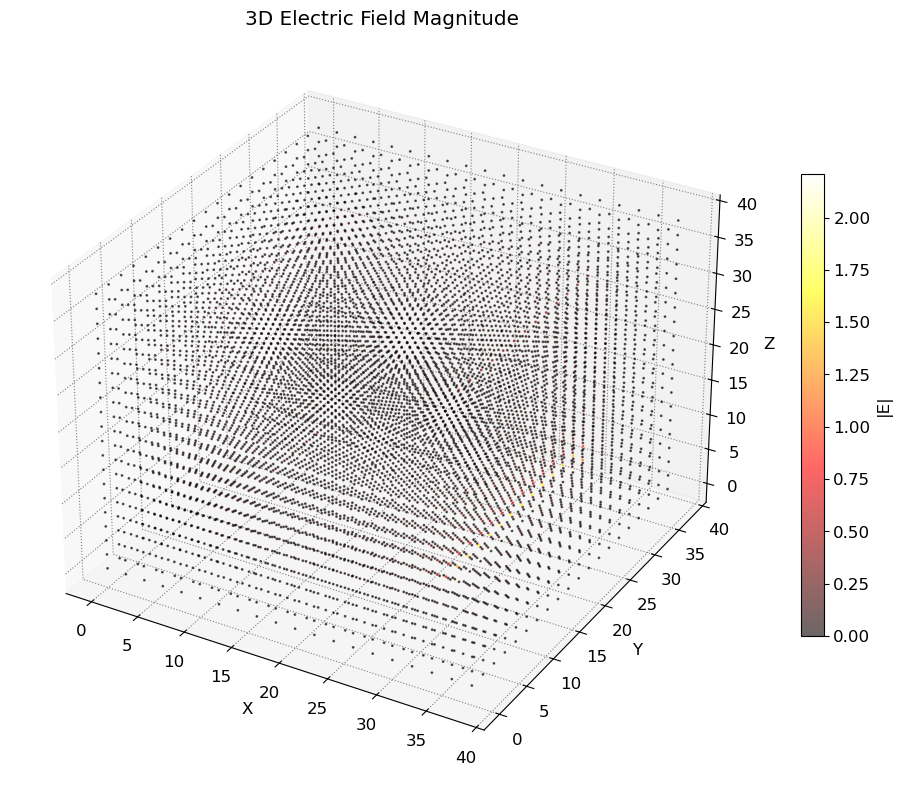

<function print(*args, sep=' ', end='\n', file=None, flush=False)>

In [9]:
# First, let's create some additional analysis and plotting functions

def plot_field_snapshots():
    """Plot 2D slices of field components at different times"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Plot Ex, Ey, Ez at z-slice through center
    z_slice = ke // 2
    
    im1 = axes[0,0].imshow(ex[:, :, z_slice].T, cmap='RdBu_r', origin='lower')
    axes[0,0].set_title('Ex field (x-y plane)')
    plt.colorbar(im1, ax=axes[0,0])
    
    im2 = axes[0,1].imshow(ey[:, :, z_slice].T, cmap='RdBu_r', origin='lower')
    axes[0,1].set_title('Ey field (x-y plane)')
    plt.colorbar(im2, ax=axes[0,1])
    
    im3 = axes[0,2].imshow(ez[:, :, z_slice].T, cmap='RdBu_r', origin='lower')
    axes[0,2].set_title('Ez field (x-y plane)')
    plt.colorbar(im3, ax=axes[0,2])
    
    # Plot through different slices
    y_slice = je // 2
    im4 = axes[1,0].imshow(ex[:, y_slice, :].T, cmap='RdBu_r', origin='lower')
    axes[1,0].set_title('Ex field (x-z plane)')
    plt.colorbar(im4, ax=axes[1,0])
    
    im5 = axes[1,1].imshow(ez[:, y_slice, :].T, cmap='RdBu_r', origin='lower')
    axes[1,1].set_title('Ez field (x-z plane)')
    plt.colorbar(im5, ax=axes[1,1])
    
    # Show dielectric sphere location
    sphere_mask = np.zeros((ie, je))
    for i in range(ie):
        for j in range(je):
            dist = sqrt((ic-i)**2 + (jc-j)**2)
            sphere_mask[i,j] = 1 if dist <= radius else 0
    
    im6 = axes[1,2].imshow(sphere_mask.T, cmap='viridis', origin='lower')
    axes[1,2].set_title('Dielectric Sphere Location')
    plt.colorbar(im6, ax=axes[1,2])
    
    plt.tight_layout()
    plt.show()

def plot_3d_field_volume():
    """Create 3D visualization of field strength"""
    from mpl_toolkits.mplot3d import Axes3D
    
    # Create a 3D scatter plot showing field strength
    fig = plt.figure(figsize=(12, 10))
    
    # Sample every few points to avoid overcrowding
    stride = 2
    X, Y, Z = np.meshgrid(range(0, je, stride), 
                         range(0, ie, stride), 
                         range(0, ke, stride))
    
    # Calculate field magnitude
    E_magnitude = np.sqrt(ex[::stride, ::stride, ::stride]**2 + 
                         ey[::stride, ::stride, ::stride]**2 + 
                         ez[::stride, ::stride, ::stride]**2)
    
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot points with color indicating field strength
    scatter = ax.scatter(X, Y, Z, c=E_magnitude.ravel(), 
                        cmap='hot', alpha=0.6, s=1)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Electric Field Magnitude')
    plt.colorbar(scatter, ax=ax, shrink=0.6, label='|E|')
    
    plt.show()

def plot_field_components_along_lines():
    """Plot field components along specific lines through the domain"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Line through center in x-direction
    j_center, k_center = je//2, ke//2
    x_positions = np.arange(ie)
    
    axes[0,0].plot(x_positions, ex[:, j_center, k_center], 'r-', label='Ex')
    axes[0,0].plot(x_positions, ey[:, j_center, k_center], 'g-', label='Ey')
    axes[0,0].plot(x_positions, ez[:, j_center, k_center], 'b-', label='Ez')
    axes[0,0].set_xlabel('X position')
    axes[0,0].set_ylabel('Field Strength')
    axes[0,0].set_title('Fields along X-axis through center')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Line through center in y-direction
    i_center, k_center = ie//2, ke//2
    y_positions = np.arange(je)
    
    axes[0,1].plot(y_positions, ex[i_center, :, k_center], 'r-', label='Ex')
    axes[0,1].plot(y_positions, ey[i_center, :, k_center], 'g-', label='Ey')
    axes[0,1].plot(y_positions, ez[i_center, :, k_center], 'b-', label='Ez')
    axes[0,1].set_xlabel('Y position')
    axes[0,1].set_ylabel('Field Strength')
    axes[0,1].set_title('Fields along Y-axis through center')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Field magnitude along diagonal
    diagonal_length = min(ie, je)
    diagonal_ex = np.array([ex[i, i, k_center] for i in range(diagonal_length)])
    diagonal_ey = np.array([ey[i, i, k_center] for i in range(diagonal_length)])
    diagonal_ez = np.array([ez[i, i, k_center] for i in range(diagonal_length)])
    diagonal_mag = np.sqrt(diagonal_ex**2 + diagonal_ey**2 + diagonal_ez**2)
    
    axes[1,0].plot(range(diagonal_length), diagonal_mag, 'k-', linewidth=2, label='|E|')
    axes[1,0].plot(range(diagonal_length), diagonal_ex, 'r--', alpha=0.7, label='Ex')
    axes[1,0].plot(range(diagonal_length), diagonal_ey, 'g--', alpha=0.7, label='Ey')
    axes[1,0].plot(range(diagonal_length), diagonal_ez, 'b--', alpha=0.7, label='Ez')
    axes[1,0].set_xlabel('Diagonal Position')
    axes[1,0].set_ylabel('Field Strength')
    axes[1,0].set_title('Fields along Diagonal')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Compare fields inside vs outside sphere
    inside_fields = []
    outside_fields = []
    positions = []
    
    for i in range(ia, ib+1):
        for j in range(ja, jb+1):
            dist = sqrt((ic-i)**2 + (jc-j)**2 + (kc-k_center)**2)
            field_mag = sqrt(ex[i,j,k_center]**2 + ey[i,j,k_center]**2 + ez[i,j,k_center]**2)
            positions.append(dist)
            if dist <= radius:
                inside_fields.append(field_mag)
            else:
                outside_fields.append(field_mag)
    
    axes[1,1].hist([inside_fields, outside_fields], bins=20, 
                  label=['Inside Sphere', 'Outside Sphere'], alpha=0.7)
    axes[1,1].set_xlabel('Field Magnitude')
    axes[1,1].set_ylabel('Count')
    axes[1,1].set_title('Field Distribution: Inside vs Outside Sphere')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_frequency_domain_analysis():
    """Plot frequency domain results in different ways"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Original frequency response plot (your code)
    scale = np.array((0.1, 0.5, 0.7))
    for m in range(number_of_frequencies):
        ax = axes[0,0]
        x_array = np.arange(-20, 20, step=1)
        ax.plot(x_array, amp[m, :], linewidth=2, label=f'{freq[m]/1e6:.0f} MHz')
        ax.set_xlabel('Position (cm)')
        ax.set_ylabel('Amplitude')
        ax.set_title('Frequency Response - Original')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # Frequency spectrum at center point
    center_amplitude = []
    for m in range(number_of_frequencies):
        center_amp = sqrt(real_pt[m, ic, jc, kc]**2 + imag_pt[m, ic, jc, kc]**2)
        center_amplitude.append(center_amp)
    
    axes[0,1].bar(range(number_of_frequencies), center_amplitude, 
                 color=['red', 'green', 'blue'], alpha=0.7)
    axes[0,1].set_xticks(range(number_of_frequencies))
    axes[0,1].set_xticklabels([f'{f/1e6:.0f} MHz' for f in freq])
    axes[0,1].set_ylabel('Amplitude at Center')
    axes[0,1].set_title('Frequency Response at Center')
    axes[0,1].grid(True, alpha=0.3)
    
    # 2D map of response at specific frequency
    freq_idx = 1  # 200 MHz
    response_map = np.zeros((ie, je))
    for i in range(ie):
        for j in range(je):
            response_map[i,j] = sqrt(real_pt[freq_idx, i, j, kc]**2 + 
                                   imag_pt[freq_idx, i, j, kc]**2)
    
    im = axes[1,0].imshow(response_map.T, cmap='viridis', origin='lower')
    axes[1,0].set_title(f'Frequency Response at {freq[freq_idx]/1e6:.0f} MHz')
    axes[1,0].set_xlabel('X')
    axes[1,0].set_ylabel('Y')
    plt.colorbar(im, ax=axes[1,0])
    
    # Phase information
    phase_map = np.arctan2(imag_pt[freq_idx, :, :, kc], 
                          real_pt[freq_idx, :, :, kc])
    im2 = axes[1,1].imshow(phase_map.T, cmap='hsv', origin='lower')
    axes[1,1].set_title(f'Phase at {freq[freq_idx]/1e6:.0f} MHz')
    axes[1,1].set_xlabel('X')
    axes[1,1].set_ylabel('Y')
    plt.colorbar(im2, ax=axes[1,1])
    
    plt.tight_layout()
    plt.show()

def plot_animation_frames():
    """Create multiple time snapshots to show field evolution"""
    # This would normally be an animation, but we'll show key frames
    # Since we only have final state, we'll show different components
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Show different field components with different colormaps
    im1 = axes[0].imshow(ez[:, :, kc].T, cmap='seismic', origin='lower')
    axes[0].set_title('Ez Component')
    axes[0].set_xlabel('X')
    axes[0].set_ylabel('Y')
    plt.colorbar(im1, ax=axes[0])
    
    im2 = axes[1].imshow(np.sqrt(ex**2 + ey**2 + ez**2)[:, :, kc].T, 
                        cmap='hot', origin='lower')
    axes[1].set_title('Total Field Magnitude')
    axes[1].set_xlabel('X')
    axes[1].set_ylabel('Y')
    plt.colorbar(im2, ax=axes[1])
    
    # Show the difference from incident field
    incident_approx = np.max(ez) * np.exp(-0.5*((np.arange(ie)-ic)**2/(spread**2)))
    diff_field = ez[:, jc, kc] - incident_approx
    axes[2].plot(range(ie), ez[:, jc, kc], 'b-', label='Total Field')
    axes[2].plot(range(ie), incident_approx, 'r--', label='Incident Field')
    axes[2].plot(range(ie), diff_field, 'g-', label='Scattered Field')
    axes[2].set_xlabel('X position')
    axes[2].set_ylabel('Field Strength')
    axes[2].set_title('Field Decomposition')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_comparative_analysis():
    """Compare different aspects of the simulation"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Material properties visualization
    eps_map = np.zeros((ie, je))
    for i in range(ie):
        for j in range(je):
            eps_map[i,j] = 1/gax[i,j,kc]  # Approximate epsilon from gax
    
    im1 = axes[0,0].imshow(eps_map.T, cmap='viridis', origin='lower')
    axes[0,0].set_title('Relative Permittivity Distribution')
    axes[0,0].set_xlabel('X')
    axes[0,0].set_ylabel('Y')
    plt.colorbar(im1, ax=axes[0,0])
    
    # Field enhancement factor
    enhancement = np.zeros((ie, je))
    max_incident = np.max(np.abs(ez_inc))
    for i in range(ie):
        for j in range(je):
            enhancement[i,j] = np.abs(ez[i,j,kc]) / max_incident if max_incident > 0 else 0
    
    im2 = axes[0,1].imshow(enhancement.T, cmap='RdYlBu_r', origin='lower', 
                          vmin=0, vmax=2)
    axes[0,1].set_title('Field Enhancement Factor')
    axes[0,1].set_xlabel('X')
    axes[0,1].set_ylabel('Y')
    plt.colorbar(im2, ax=axes[0,1])
    
    # Energy density distribution
    energy_density = 0.5 * epsz * (ex**2 + ey**2 + ez**2)
    im3 = axes[1,0].imshow(energy_density[:, :, kc].T, cmap='hot', origin='lower')
    axes[1,0].set_title('Energy Density Distribution')
    axes[1,0].set_xlabel('X')
    axes[1,0].set_ylabel('Y')
    plt.colorbar(im3, ax=axes[1,0])
    
    # Radial field distribution
    radial_distances = []
    radial_fields = []
    for i in range(ie):
        for j in range(je):
            r = sqrt((i-ic)**2 + (j-jc)**2)
            if r < min(ic, jc):  # Only consider points within domain
                radial_distances.append(r)
                radial_fields.append(np.abs(ez[i,j,kc]))
    
    axes[1,1].scatter(radial_distances, radial_fields, alpha=0.5, s=10)
    axes[1,1].set_xlabel('Radial Distance from Center')
    axes[1,1].set_ylabel('|Ez| Field Strength')
    axes[1,1].set_title('Radial Field Distribution')
    axes[1,1].grid(True, alpha=0.3)
    
    # Add vertical line at sphere radius
    axes[1,1].axvline(x=radius, color='red', linestyle='--', 
                     label=f'Sphere Radius ({radius})')
    axes[1,1].legend()
    
    plt.tight_layout()
    plt.show()

# Now run all the plotting functions
print("1. Field Component Snapshots:")
plot_field_snapshots()

print("2. Field Components Along Lines:")
plot_field_components_along_lines()

print("3. Frequency Domain Analysis:")
plot_frequency_domain_analysis()

print("4. Comparative Analysis:")
plot_comparative_analysis()

print("5. Animation Frames (Static):")
plot_animation_frames()

# For 3D plot (optional - can be slow)
try:
    print("6. 3D Field Volume (may take a moment):")
    plot_3d_field_volume()
except ImportError:
    print("3D plotting not available - install mpl_toolkits for 3D plots")

# Additional specialized plots
def plot_pml_effectiveness():
    """Plot to show PML boundary effectiveness"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Show field decay near boundaries
    boundary_distance = []
    field_strength = []
    
    for i in range(ie):
        dist_to_boundary = min(i, ie-1-i)
        boundary_distance.append(dist_to_boundary)
        field_strength.append(np.abs(ez[i, jc, kc]))
    
    ax1.plot(boundary_distance, field_strength, 'bo-', alpha=0.7)
    ax1.set_xlabel('Distance from Boundary')
    ax1.set_ylabel('|Ez| Field Strength')
    ax1.set_title('Field Decay Near Boundaries')
    ax1.grid(True, alpha=0.3)
    
    # Compare center vs edge fields over time (simulated)
    # Since we don't have time history, we'll use spatial variation
    center_field = np.abs(ez[ic, jc, kc])
    edge_fields = [ez[0, jc, kc], ez[-1, jc, kc], ez[ic, 0, kc], ez[ic, -1, kc]]
    positions = ['Left', 'Right', 'Bottom', 'Top']
    
    ax2.bar(positions, np.abs(edge_fields)/center_field, alpha=0.7, color='orange')
    ax2.set_ylabel('Field Relative to Center')
    ax2.set_title('Boundary Field Strength Relative to Center')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print

CONTOUR PLOTS OF ELECTROMAGNETIC FIELDS
1. Basic Field Component Contours:


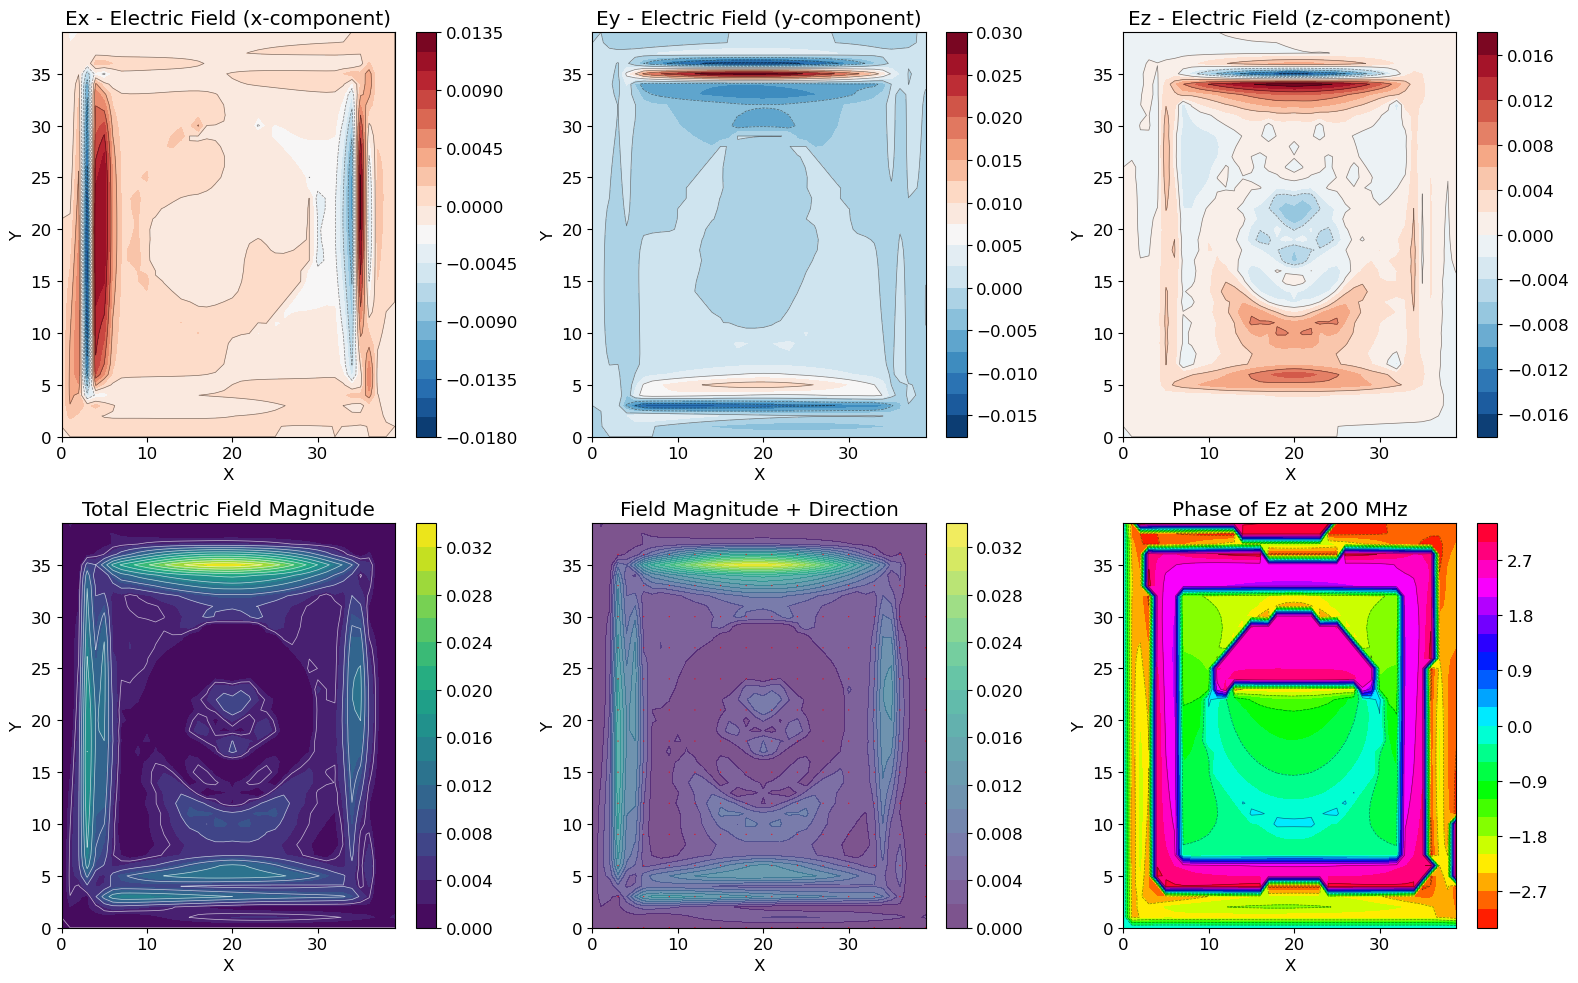

2. Detailed Multi-Slice Contour Analysis:


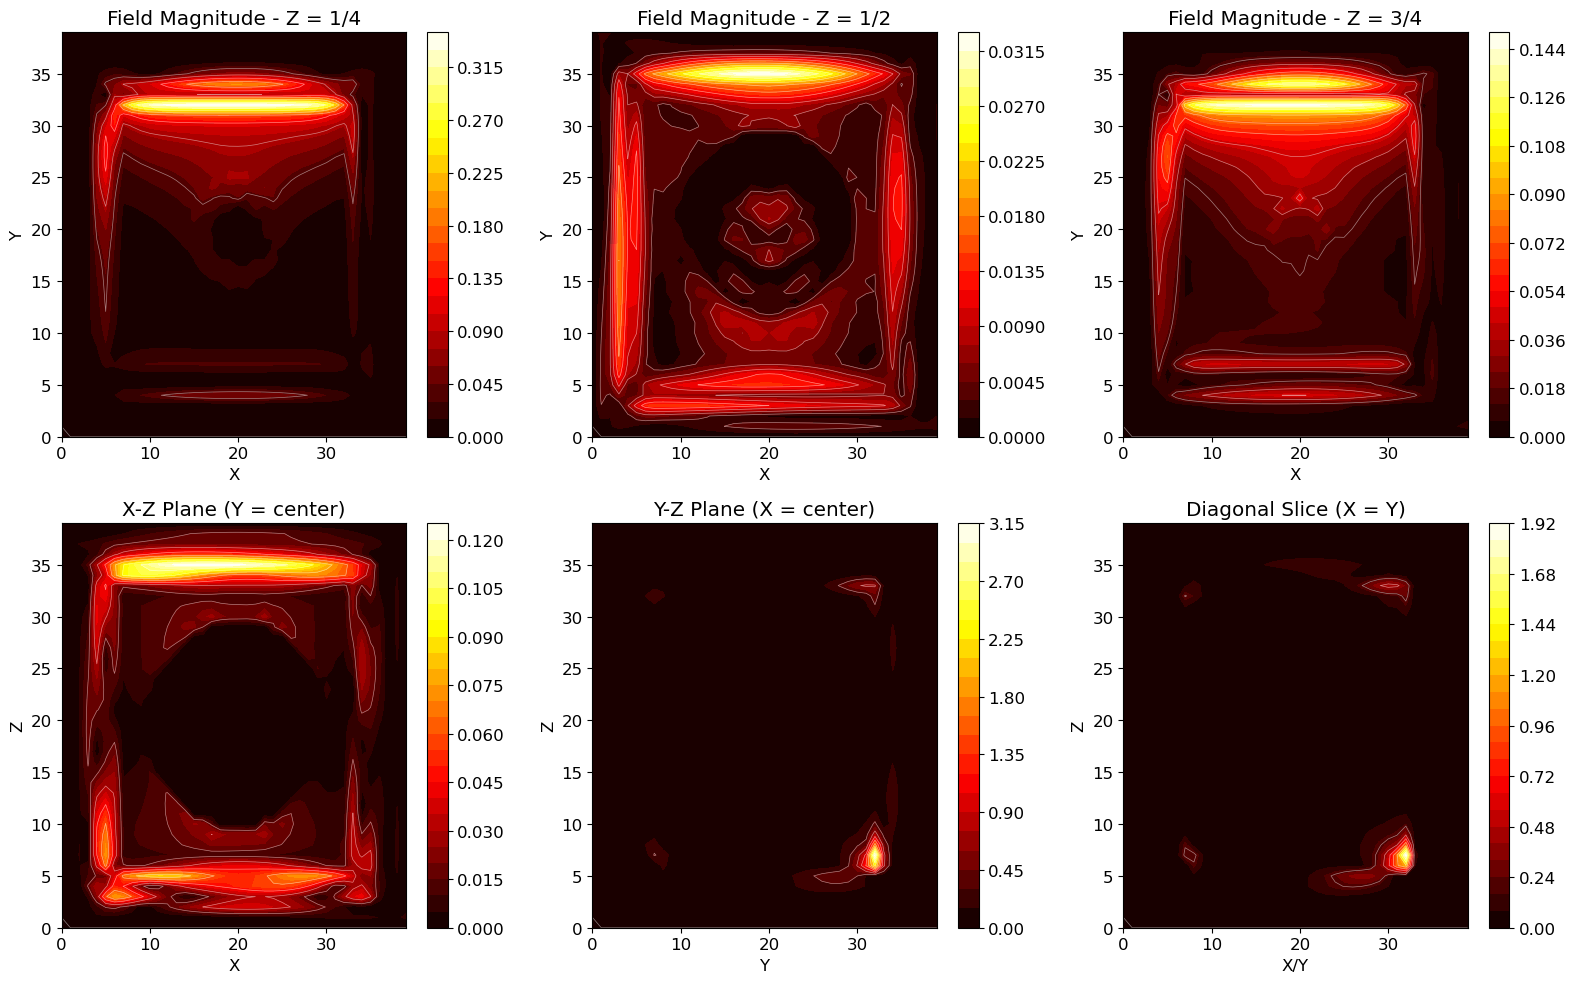

3. Comparative Field Analysis Contours:


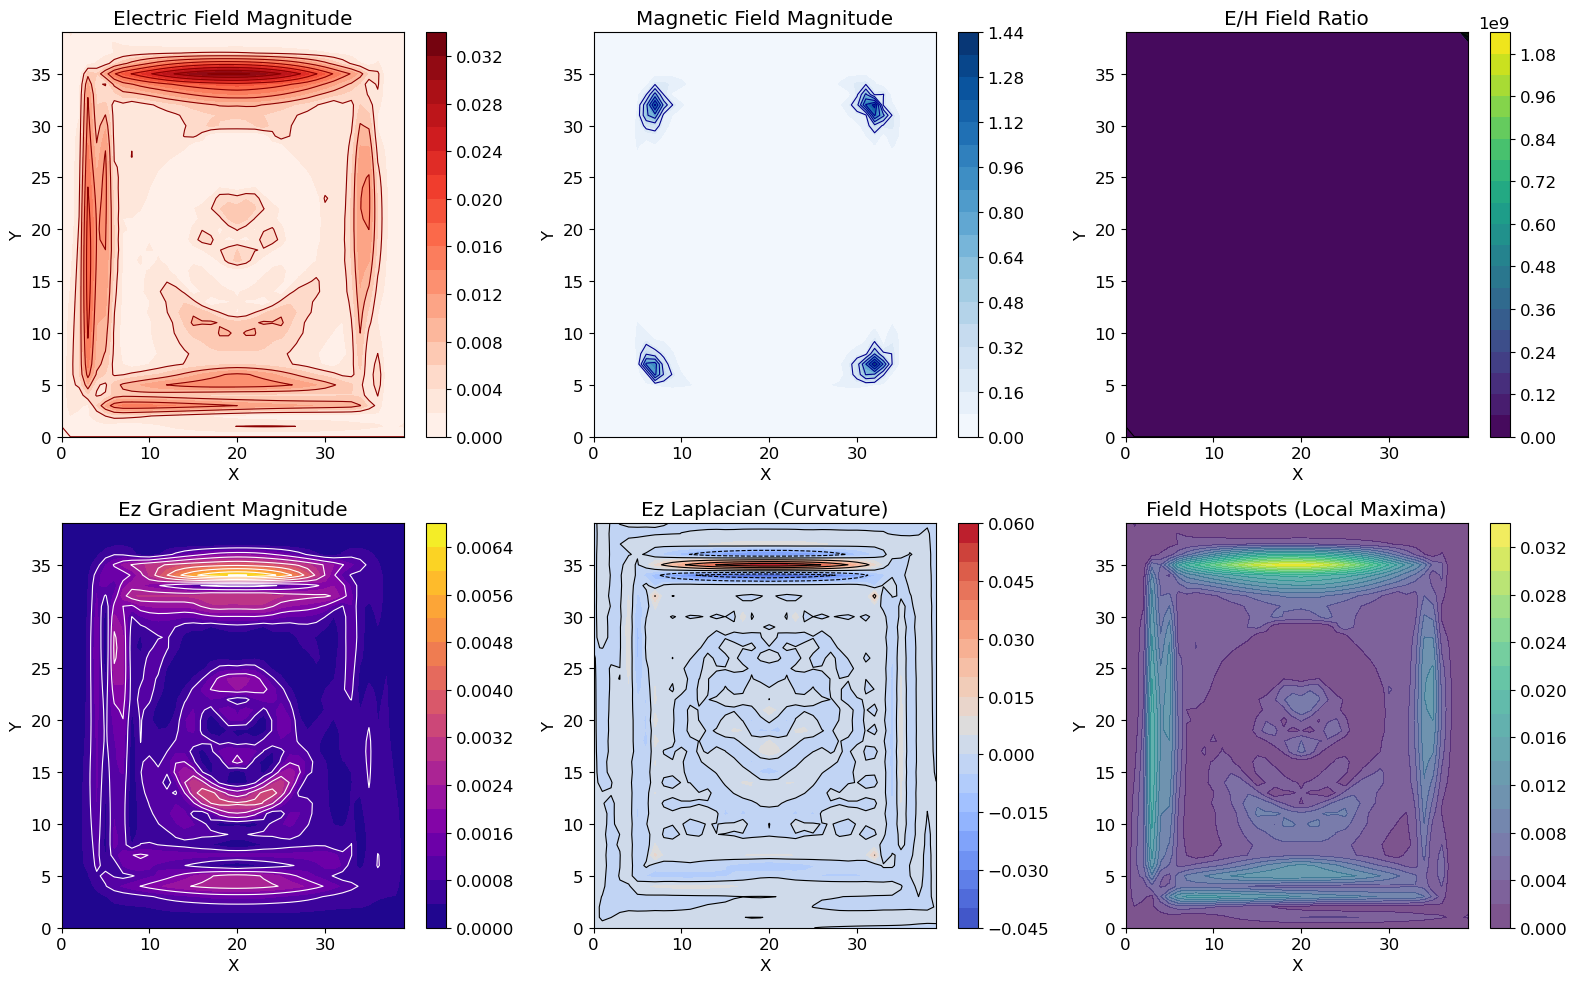

4. Frequency Domain Contours:


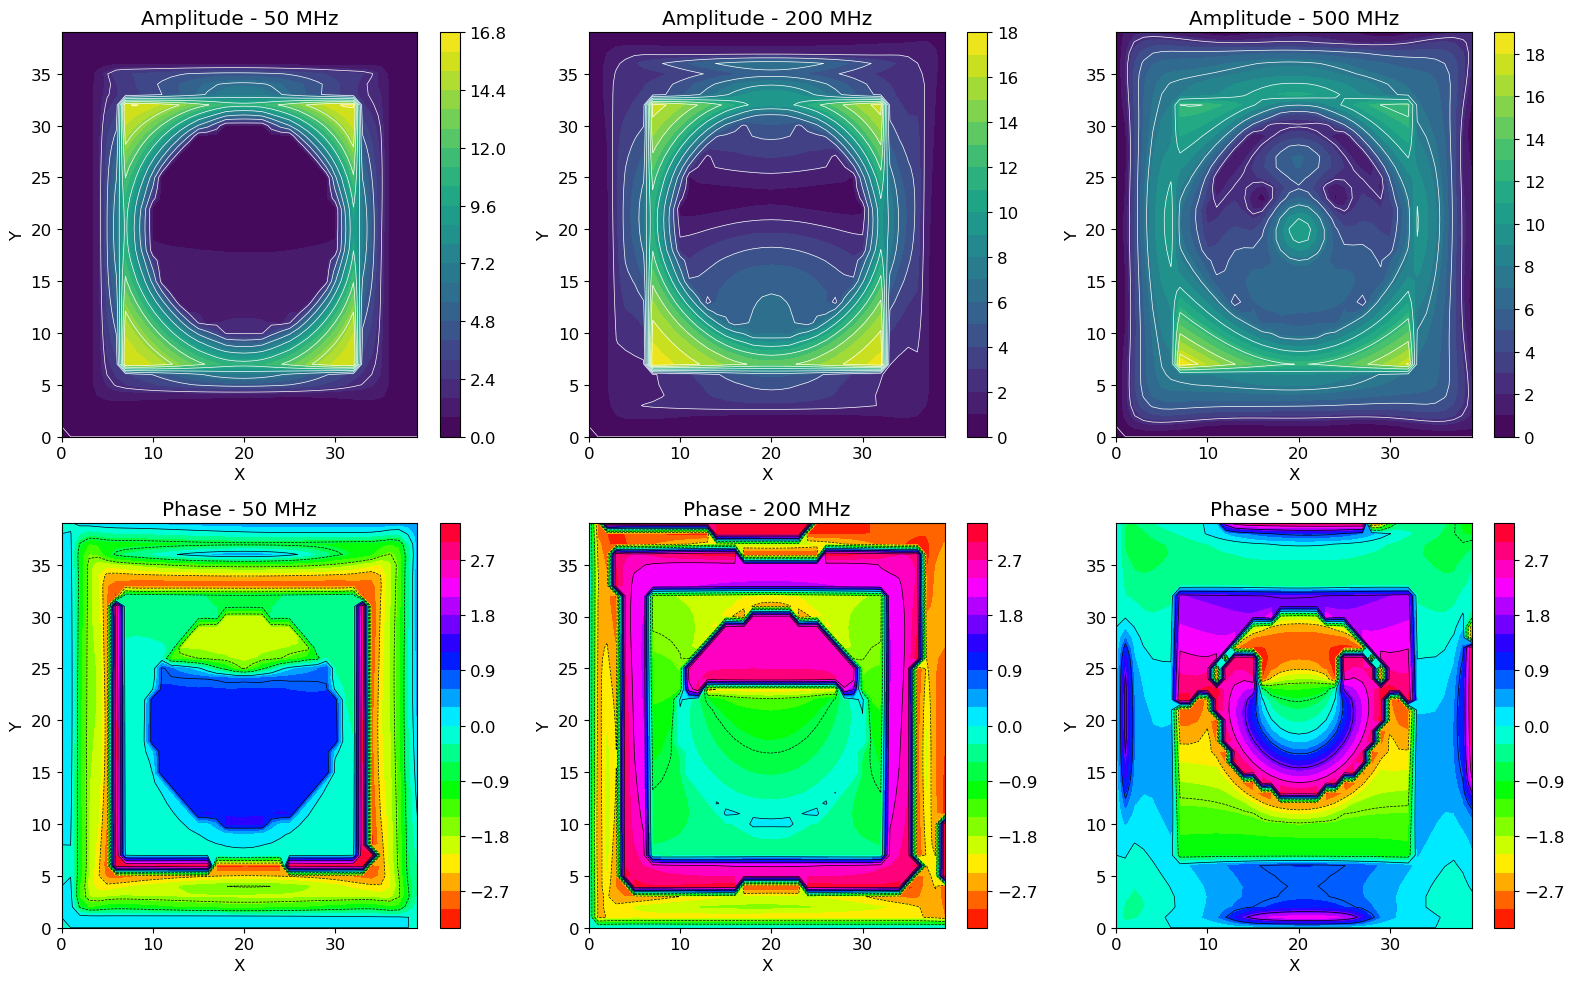

5. Contour Level Comparison:


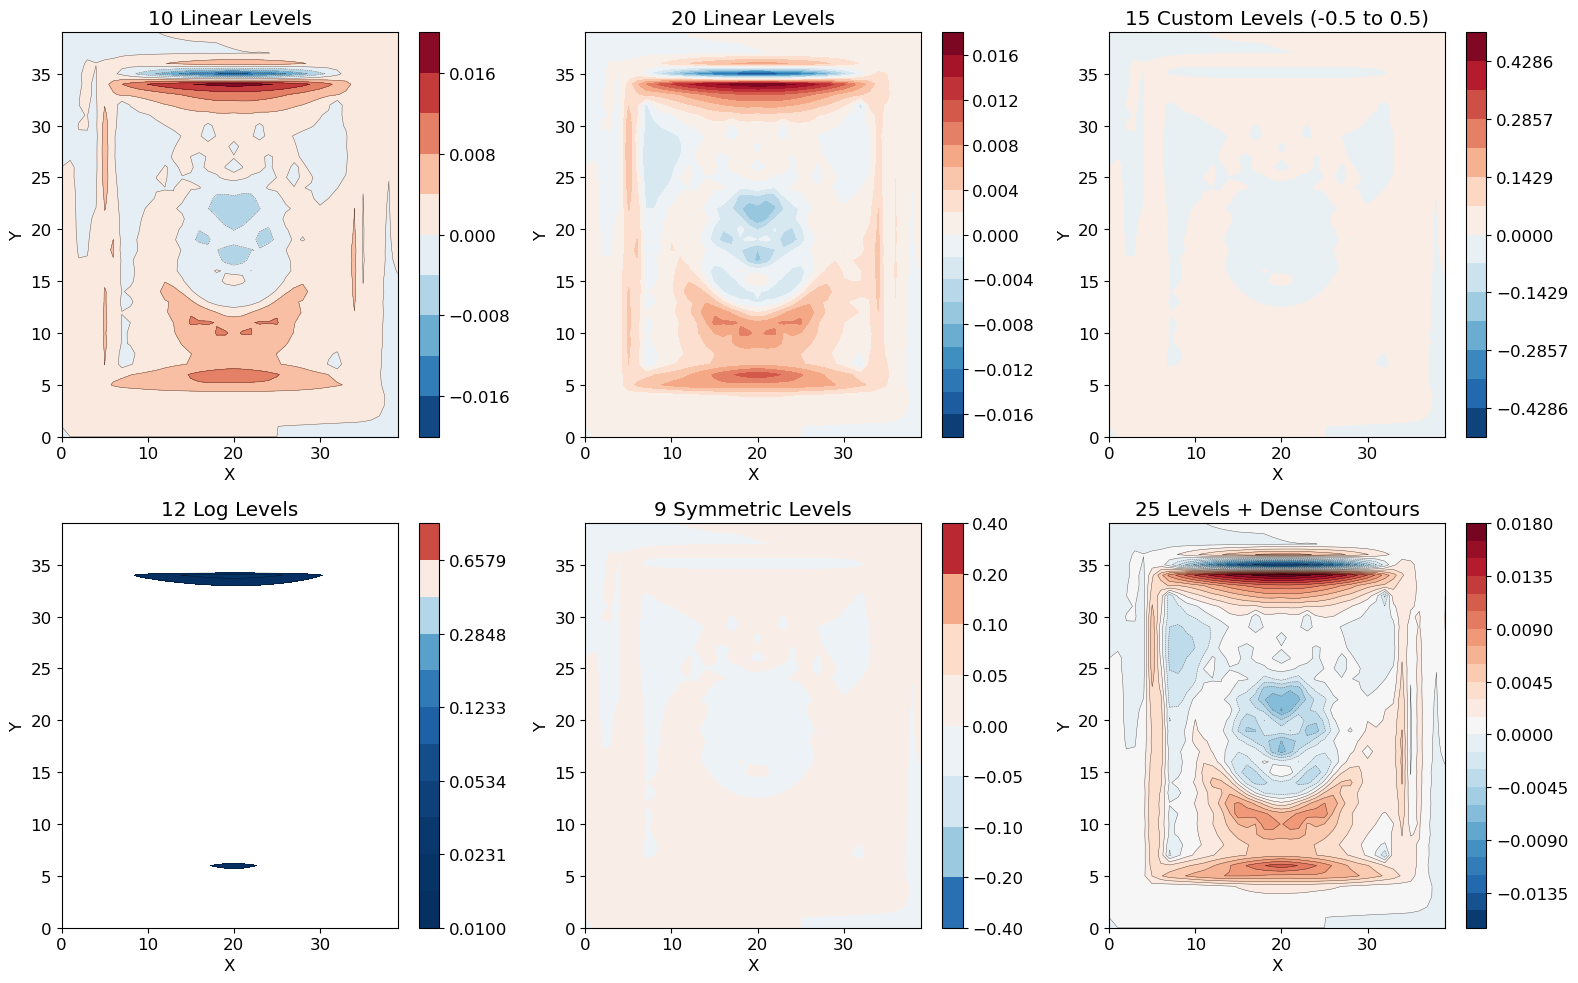

6. Sphere Interaction Contours:


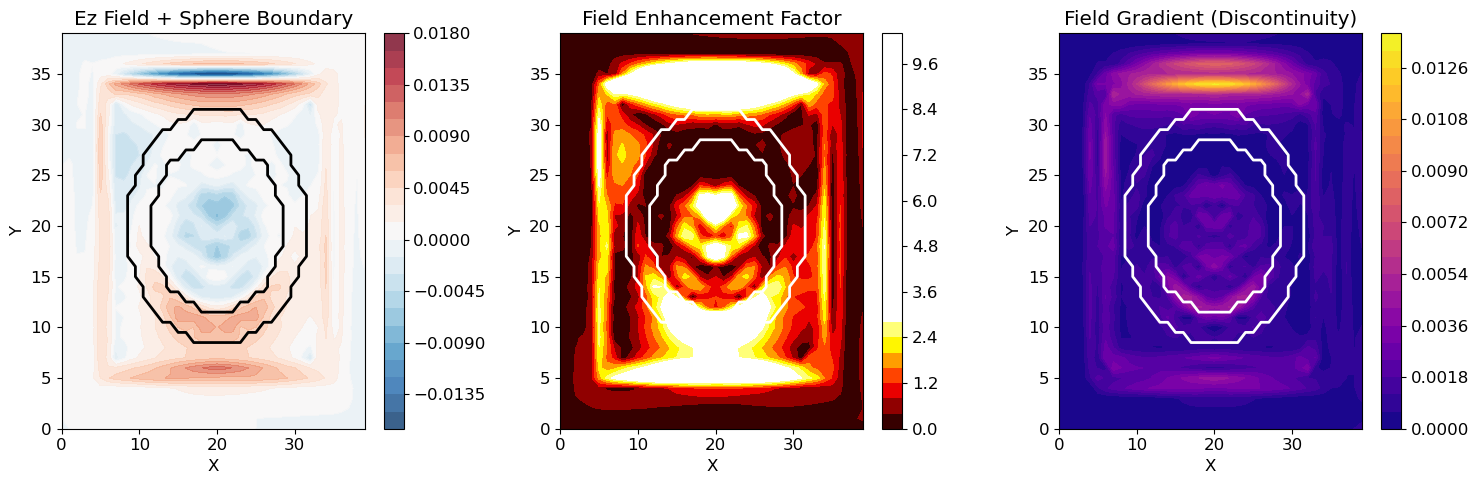

In [10]:
# Contour plots for field visualization
print("CONTOUR PLOTS OF ELECTROMAGNETIC FIELDS")
print("=" * 50)

def plot_contour_fields():
    """Create contour plots of field components"""
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    
    # Create coordinate grids
    X, Y = np.meshgrid(range(ie), range(je))
    z_slice = ke // 2
    
    # Electric field contours
    # Ex component
    contour1 = axes[0,0].contourf(X, Y, ex[:, :, z_slice].T, levels=20, cmap='RdBu_r')
    axes[0,0].contour(X, Y, ex[:, :, z_slice].T, levels=10, colors='black', linewidths=0.5, alpha=0.5)
    axes[0,0].set_title('Ex - Electric Field (x-component)')
    axes[0,0].set_xlabel('X')
    axes[0,0].set_ylabel('Y')
    plt.colorbar(contour1, ax=axes[0,0])
    
    # Ey component
    contour2 = axes[0,1].contourf(X, Y, ey[:, :, z_slice].T, levels=20, cmap='RdBu_r')
    axes[0,1].contour(X, Y, ey[:, :, z_slice].T, levels=10, colors='black', linewidths=0.5, alpha=0.5)
    axes[0,1].set_title('Ey - Electric Field (y-component)')
    axes[0,1].set_xlabel('X')
    axes[0,1].set_ylabel('Y')
    plt.colorbar(contour2, ax=axes[0,1])
    
    # Ez component
    contour3 = axes[0,2].contourf(X, Y, ez[:, :, z_slice].T, levels=20, cmap='RdBu_r')
    axes[0,2].contour(X, Y, ez[:, :, z_slice].T, levels=10, colors='black', linewidths=0.5, alpha=0.5)
    axes[0,2].set_title('Ez - Electric Field (z-component)')
    axes[0,2].set_xlabel('X')
    axes[0,2].set_ylabel('Y')
    plt.colorbar(contour3, ax=axes[0,2])
    
    # Total field magnitude
    E_magnitude = np.sqrt(ex**2 + ey**2 + ez**2)
    contour4 = axes[1,0].contourf(X, Y, E_magnitude[:, :, z_slice].T, levels=20, cmap='viridis')
    axes[1,0].contour(X, Y, E_magnitude[:, :, z_slice].T, levels=10, colors='white', linewidths=0.5, alpha=0.7)
    axes[1,0].set_title('Total Electric Field Magnitude')
    axes[1,0].set_xlabel('X')
    axes[1,0].set_ylabel('Y')
    plt.colorbar(contour4, ax=axes[1,0])
    
    # Field direction (quiver plot combined with contour)
    contour5 = axes[1,1].contourf(X, Y, E_magnitude[:, :, z_slice].T, levels=20, cmap='viridis', alpha=0.7)
    # Add vector field (subsampled for clarity)
    stride = 3
    X_sub = X[::stride, ::stride]
    Y_sub = Y[::stride, ::stride]
    Ex_sub = ex[::stride, ::stride, z_slice].T
    Ey_sub = ey[::stride, ::stride, z_slice].T
    
    axes[1,1].quiver(X_sub, Y_sub, Ex_sub, Ey_sub, scale=5, color='red', alpha=0.8)
    axes[1,1].set_title('Field Magnitude + Direction')
    axes[1,1].set_xlabel('X')
    axes[1,1].set_ylabel('Y')
    plt.colorbar(contour5, ax=axes[1,1])
    
    # Phase of Ez field (using Fourier data)
    freq_idx = 1  # 200 MHz
    phase = np.arctan2(imag_pt[freq_idx, :, :, z_slice], real_pt[freq_idx, :, :, z_slice])
    contour6 = axes[1,2].contourf(X, Y, phase.T, levels=20, cmap='hsv')
    axes[1,2].contour(X, Y, phase.T, levels=10, colors='black', linewidths=0.5, alpha=0.5)
    axes[1,2].set_title(f'Phase of Ez at {freq[freq_idx]/1e6:.0f} MHz')
    axes[1,2].set_xlabel('X')
    axes[1,2].set_ylabel('Y')
    plt.colorbar(contour6, ax=axes[1,2])
    
    plt.tight_layout()
    plt.show()

def plot_detailed_contour_analysis():
    """More detailed contour analysis with different slices"""
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    
    # Different z-slices
    z_slices = [ke//4, ke//2, 3*ke//4]
    slice_names = ['Z = 1/4', 'Z = 1/2', 'Z = 3/4']
    
    E_magnitude = np.sqrt(ex**2 + ey**2 + ez**2)
    
    for i, (z_slice, name) in enumerate(zip(z_slices, slice_names)):
        X, Y = np.meshgrid(range(ie), range(je))
        contour = axes[0,i].contourf(X, Y, E_magnitude[:, :, z_slice].T, levels=25, cmap='hot')
        axes[0,i].contour(X, Y, E_magnitude[:, :, z_slice].T, levels=10, colors='white', linewidths=0.5, alpha=0.5)
        axes[0,i].set_title(f'Field Magnitude - {name}')
        axes[0,i].set_xlabel('X')
        axes[0,i].set_ylabel('Y')
        plt.colorbar(contour, ax=axes[0,i])
    
    # Different cross-sections
    # X-Z plane at center Y
    X, Z = np.meshgrid(range(ie), range(ke))
    contour4 = axes[1,0].contourf(X, Z, E_magnitude[:, je//2, :].T, levels=25, cmap='hot')
    axes[1,0].contour(X, Z, E_magnitude[:, je//2, :].T, levels=10, colors='white', linewidths=0.5, alpha=0.5)
    axes[1,0].set_title('X-Z Plane (Y = center)')
    axes[1,0].set_xlabel('X')
    axes[1,0].set_ylabel('Z')
    plt.colorbar(contour4, ax=axes[1,0])
    
    # Y-Z plane at center X
    Y, Z = np.meshgrid(range(je), range(ke))
    contour5 = axes[1,1].contourf(Y, Z, E_magnitude[ie//2, :, :].T, levels=25, cmap='hot')
    axes[1,1].contour(Y, Z, E_magnitude[ie//2, :, :].T, levels=10, colors='white', linewidths=0.5, alpha=0.5)
    axes[1,1].set_title('Y-Z Plane (X = center)')
    axes[1,1].set_xlabel('Y')
    axes[1,1].set_ylabel('Z')
    plt.colorbar(contour5, ax=axes[1,1])
    
    # Diagonal slice
    diagonal_slice = np.zeros((ie, ke))
    for i in range(ie):
        for k in range(ke):
            diagonal_slice[i, k] = E_magnitude[i, i, k]
    
    contour6 = axes[1,2].contourf(range(ie), range(ke), diagonal_slice.T, levels=25, cmap='hot')
    axes[1,2].contour(range(ie), range(ke), diagonal_slice.T, levels=10, colors='white', linewidths=0.5, alpha=0.5)
    axes[1,2].set_title('Diagonal Slice (X = Y)')
    axes[1,2].set_xlabel('X/Y')
    axes[1,2].set_ylabel('Z')
    plt.colorbar(contour6, ax=axes[1,2])
    
    plt.tight_layout()
    plt.show()

def plot_comparison_contours():
    """Compare different field aspects using contours"""
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    
    X, Y = np.meshgrid(range(ie), range(je))
    z_slice = ke // 2
    
    # 1. Compare E and H fields
    E_magnitude = np.sqrt(ex**2 + ey**2 + ez**2)
    H_magnitude = np.sqrt(hx**2 + hy**2 + hz**2)
    
    contour1 = axes[0,0].contourf(X, Y, E_magnitude[:, :, z_slice].T, levels=20, cmap='Reds')
    axes[0,0].contour(X, Y, E_magnitude[:, :, z_slice].T, levels=8, colors='darkred', linewidths=0.8)
    axes[0,0].set_title('Electric Field Magnitude')
    axes[0,0].set_xlabel('X')
    axes[0,0].set_ylabel('Y')
    plt.colorbar(contour1, ax=axes[0,0])
    
    contour2 = axes[0,1].contourf(X, Y, H_magnitude[:, :, z_slice].T, levels=20, cmap='Blues')
    axes[0,1].contour(X, Y, H_magnitude[:, :, z_slice].T, levels=8, colors='darkblue', linewidths=0.8)
    axes[0,1].set_title('Magnetic Field Magnitude')
    axes[0,1].set_xlabel('X')
    axes[0,1].set_ylabel('Y')
    plt.colorbar(contour2, ax=axes[0,1])
    
    # 2. Field ratio
    field_ratio = E_magnitude / (H_magnitude + 1e-12)
    contour3 = axes[0,2].contourf(X, Y, field_ratio[:, :, z_slice].T, levels=20, cmap='viridis')
    axes[0,2].contour(X, Y, field_ratio[:, :, z_slice].T, levels=8, colors='black', linewidths=0.8)
    axes[0,2].set_title('E/H Field Ratio')
    axes[0,2].set_xlabel('X')
    axes[0,2].set_ylabel('Y')
    plt.colorbar(contour3, ax=axes[0,2])
    
    # 3. Gradient magnitude (field variation)
    from scipy import ndimage
    grad_mag = ndimage.gaussian_gradient_magnitude(ez[:, :, z_slice], sigma=1)
    contour4 = axes[1,0].contourf(X, Y, grad_mag.T, levels=20, cmap='plasma')
    axes[1,0].contour(X, Y, grad_mag.T, levels=8, colors='white', linewidths=0.8)
    axes[1,0].set_title('Ez Gradient Magnitude')
    axes[1,0].set_xlabel('X')
    axes[1,0].set_ylabel('Y')
    plt.colorbar(contour4, ax=axes[1,0])
    
    # 4. Laplacian (curvature)
    laplacian = ndimage.laplace(ez[:, :, z_slice])
    contour5 = axes[1,1].contourf(X, Y, laplacian.T, levels=20, cmap='coolwarm')
    axes[1,1].contour(X, Y, laplacian.T, levels=8, colors='black', linewidths=0.8)
    axes[1,1].set_title('Ez Laplacian (Curvature)')
    axes[1,1].set_xlabel('X')
    axes[1,1].set_ylabel('Y')
    plt.colorbar(contour5, ax=axes[1,1])
    
    # 5. Field hotspots (local maxima)
    from scipy.ndimage import maximum_filter
    local_max = maximum_filter(E_magnitude[:, :, z_slice], size=5)
    hotspots = (E_magnitude[:, :, z_slice] == local_max) & (E_magnitude[:, :, z_slice] > 0.1)
    
    contour6 = axes[1,2].contourf(X, Y, E_magnitude[:, :, z_slice].T, levels=20, cmap='viridis', alpha=0.7)
    y_idx, x_idx = np.where(hotspots.T)
    axes[1,2].scatter(x_idx, y_idx, c='red', s=50, marker='x', linewidths=2)
    axes[1,2].set_title('Field Hotspots (Local Maxima)')
    axes[1,2].set_xlabel('X')
    axes[1,2].set_ylabel('Y')
    plt.colorbar(contour6, ax=axes[1,2])
    
    plt.tight_layout()
    plt.show()

def plot_frequency_domain_contours():
    """Contour plots in frequency domain"""
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    
    X, Y = np.meshgrid(range(ie), range(je))
    z_slice = ke // 2
    
    for m in range(number_of_frequencies):
        # Amplitude at each frequency
        amp_3d = np.sqrt(real_pt[m, :, :, :]**2 + imag_pt[m, :, :, :]**2)
        contour = axes[0,m].contourf(X, Y, amp_3d[:, :, z_slice].T, levels=20, cmap='viridis')
        axes[0,m].contour(X, Y, amp_3d[:, :, z_slice].T, levels=8, colors='white', linewidths=0.5)
        axes[0,m].set_title(f'Amplitude - {freq[m]/1e6:.0f} MHz')
        axes[0,m].set_xlabel('X')
        axes[0,m].set_ylabel('Y')
        plt.colorbar(contour, ax=axes[0,m])
    
    for m in range(number_of_frequencies):
        # Phase at each frequency
        phase = np.arctan2(imag_pt[m, :, :, z_slice], real_pt[m, :, :, z_slice])
        contour = axes[1,m].contourf(X, Y, phase.T, levels=20, cmap='hsv')
        axes[1,m].contour(X, Y, phase.T, levels=8, colors='black', linewidths=0.5)
        axes[1,m].set_title(f'Phase - {freq[m]/1e6:.0f} MHz')
        axes[1,m].set_xlabel('X')
        axes[1,m].set_ylabel('Y')
        plt.colorbar(contour, ax=axes[1,m])
    
    plt.tight_layout()
    plt.show()

def plot_interactive_contour_levels():
    """Show how different contour levels affect visualization"""
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    
    X, Y = np.meshgrid(range(ie), range(je))
    z_slice = ke // 2
    field_data = ez[:, :, z_slice].T
    
    # Different contour level strategies
    levels_configs = [
        (10, '10 Linear Levels'),
        (20, '20 Linear Levels'),
        (np.linspace(-0.5, 0.5, 15), '15 Custom Levels (-0.5 to 0.5)'),
        (np.geomspace(0.01, 1, 12), '12 Log Levels'),
        ([-0.4, -0.2, -0.1, -0.05, 0, 0.05, 0.1, 0.2, 0.4], '9 Symmetric Levels'),
        (25, '25 Levels + Dense Contours')
    ]
    
    for idx, (levels, title) in enumerate(levels_configs):
        row, col = idx // 3, idx % 3
        contour = axes[row, col].contourf(X, Y, field_data, levels=levels, cmap='RdBu_r')
        
        # Add contour lines for some configurations
        if idx in [0, 3, 5]:
            axes[row, col].contour(X, Y, field_data, levels=levels, colors='black', linewidths=0.3, alpha=0.7)
        
        axes[row, col].set_title(title)
        axes[row, col].set_xlabel('X')
        axes[row, col].set_ylabel('Y')
        plt.colorbar(contour, ax=axes[row, col])
    
    plt.tight_layout()
    plt.show()

# Run all contour plotting functions
print("1. Basic Field Component Contours:")
plot_contour_fields()

print("2. Detailed Multi-Slice Contour Analysis:")
plot_detailed_contour_analysis()

print("3. Comparative Field Analysis Contours:")
plot_comparison_contours()

print("4. Frequency Domain Contours:")
plot_frequency_domain_contours()

print("5. Contour Level Comparison:")
plot_interactive_contour_levels()

# Specialized contour for sphere interaction
def plot_sphere_interaction_contours():
    """Focus on how fields interact with the dielectric sphere"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    X, Y = np.meshgrid(range(ie), range(je))
    z_slice = ke // 2
    
    # Create sphere boundary overlay
    sphere_boundary = np.zeros((ie, je))
    for i in range(ie):
        for j in range(je):
            dist = sqrt((ic-i)**2 + (jc-j)**2)
            if abs(dist - radius) < 1.5:  # Highlight sphere boundary
                sphere_boundary[i, j] = 1
    
    # Ez field with sphere boundary
    contour1 = axes[0].contourf(X, Y, ez[:, :, z_slice].T, levels=25, cmap='RdBu_r', alpha=0.8)
    axes[0].contour(X, Y, sphere_boundary.T, levels=[0.5], colors='black', linewidths=2)
    axes[0].set_title('Ez Field + Sphere Boundary')
    axes[0].set_xlabel('X')
    axes[0].set_ylabel('Y')
    plt.colorbar(contour1, ax=axes[0])
    
    # Field enhancement due to sphere
    background_estimate = np.percentile(np.abs(ez), 50)  # Median as background
    enhancement = np.abs(ez[:, :, z_slice]) / (background_estimate + 1e-12)
    contour2 = axes[1].contourf(X, Y, enhancement.T, levels=25, cmap='hot', vmin=0, vmax=3)
    axes[1].contour(X, Y, sphere_boundary.T, levels=[0.5], colors='white', linewidths=2)
    axes[1].set_title('Field Enhancement Factor')
    axes[1].set_xlabel('X')
    axes[1].set_ylabel('Y')
    plt.colorbar(contour2, ax=axes[1])
    
    # Field discontinuity at sphere boundary
    grad_mag = np.sqrt(np.gradient(ez[:, :, z_slice])[0]**2 + np.gradient(ez[:, :, z_slice])[1]**2)
    contour3 = axes[2].contourf(X, Y, grad_mag.T, levels=25, cmap='plasma')
    axes[2].contour(X, Y, sphere_boundary.T, levels=[0.5], colors='white', linewidths=2)
    axes[2].set_title('Field Gradient (Discontinuity)')
    axes[2].set_xlabel('X')
    axes[2].set_ylabel('Y')
    plt.colorbar(contour3, ax=axes[2])
    
    plt.tight_layout()
    plt.show()

print("6. Sphere Interaction Contours:")
plot_sphere_interaction_contours()

3D CONTOUR PLOTS - FIXED VERSION
1. Fixed 3D Contour Plots:


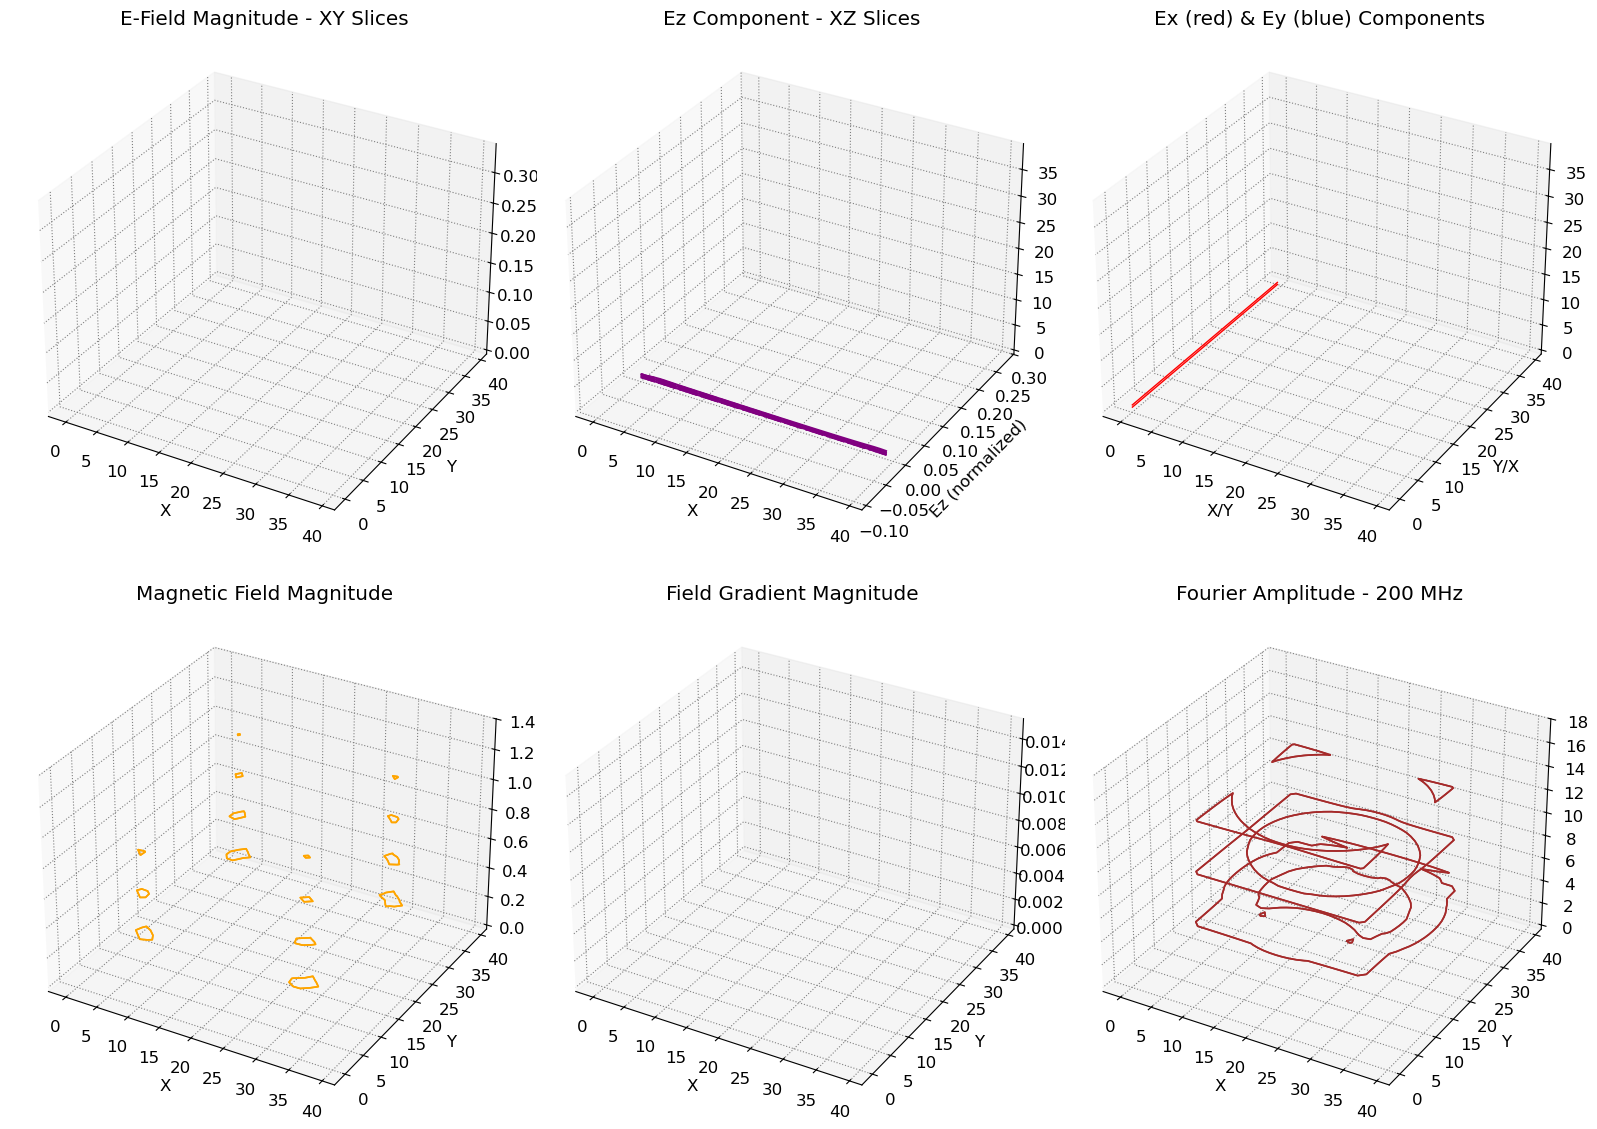

2. 3D Filled Contour Slices:


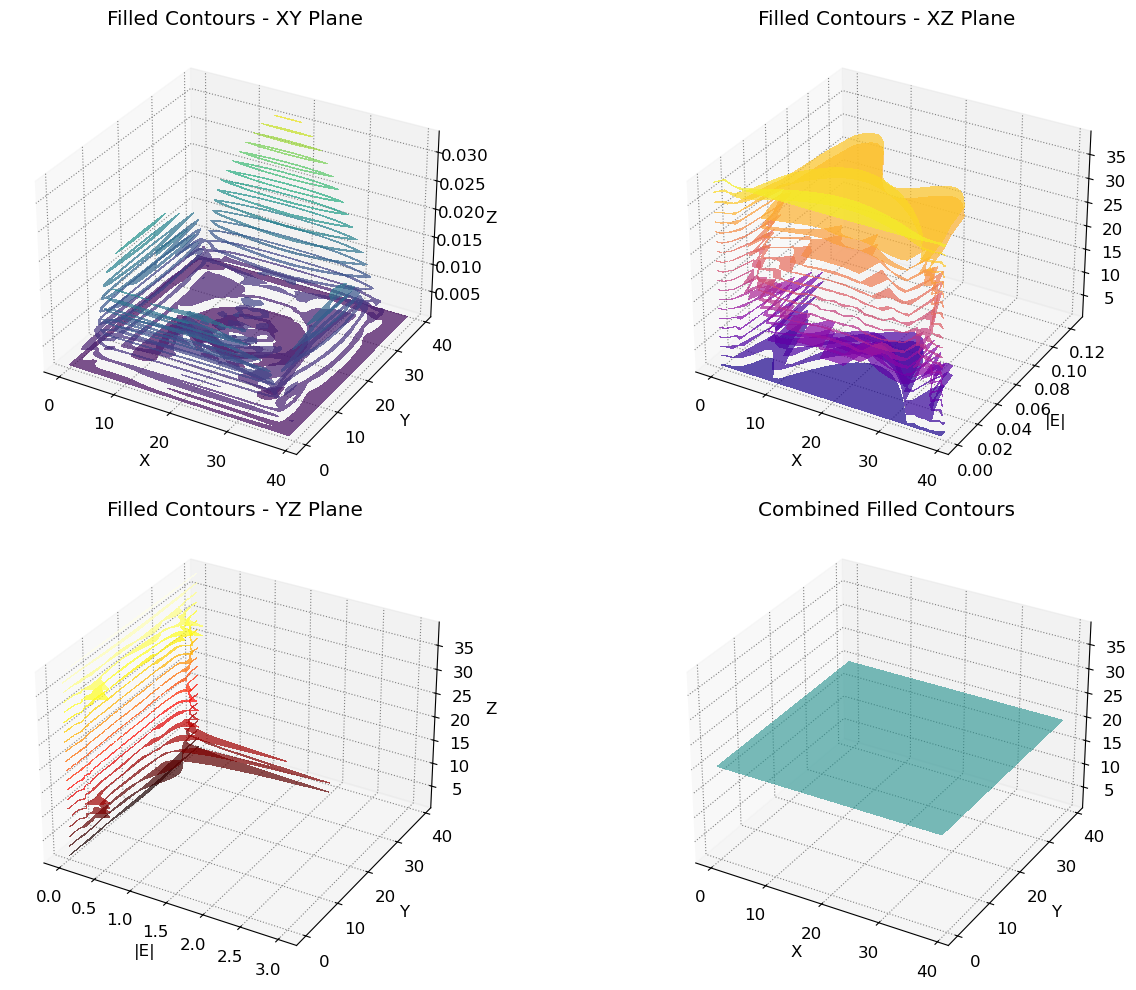

3. Sphere-Centered Contour Analysis:


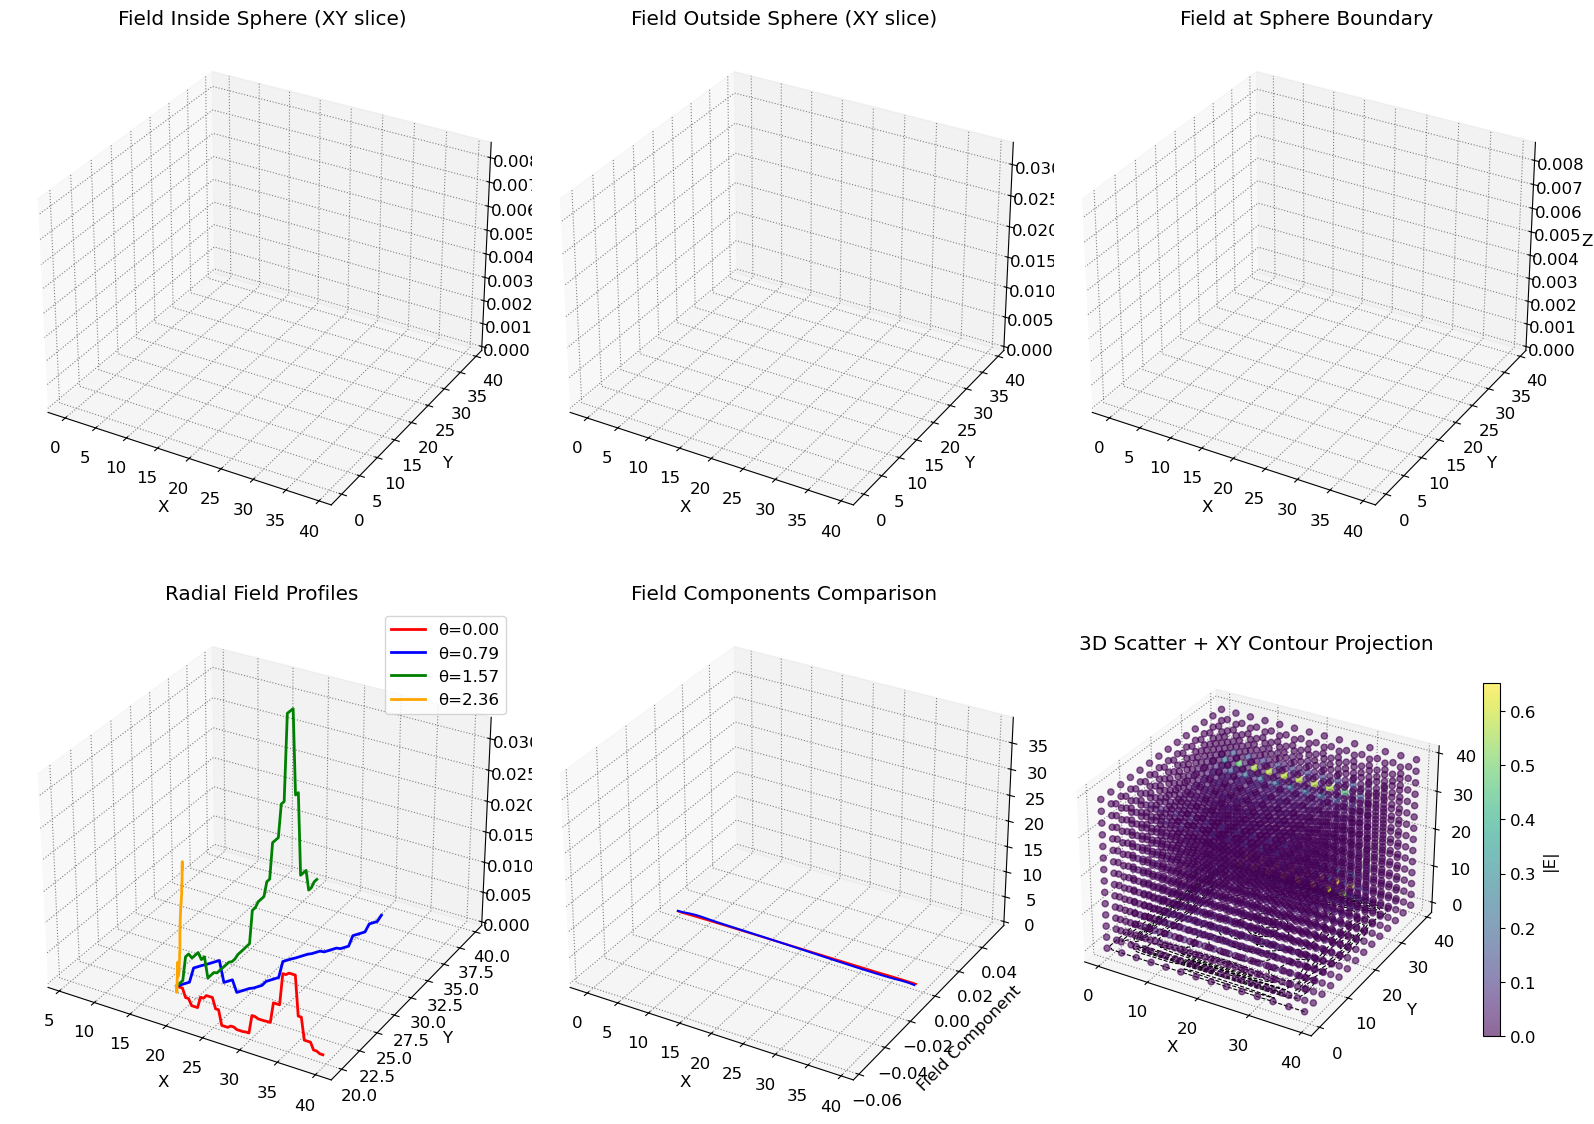

4. Simple 3D Surface Views:


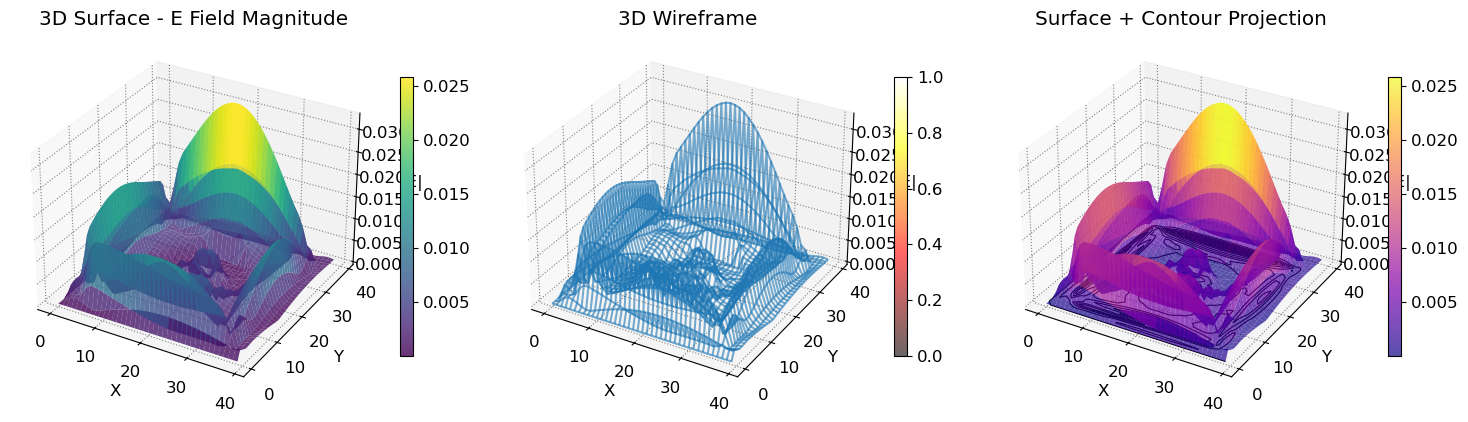

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

print("3D CONTOUR PLOTS - FIXED VERSION")
print("=" * 50)

def plot_3d_contour_fixed():
    """Create proper 3D contour plots with increasing levels"""
    fig = plt.figure(figsize=(16, 12))
    
    # Create coordinate arrays
    x = np.arange(ie)
    y = np.arange(je) 
    z = np.arange(ke)
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
    
    # Calculate field magnitudes
    E_magnitude = np.sqrt(ex**2 + ey**2 + ez**2)
    Ez_normalized = ez / (np.max(np.abs(ez)) + 1e-12)  # Normalize for better visualization
    
    # Plot 1: Electric field magnitude - XY slices
    ax1 = fig.add_subplot(231, projection='3d')
    
    # Use properly ordered, increasing levels
    levels_e = np.linspace(E_magnitude.min(), E_magnitude.max(), 8)
    levels_e = levels_e[1:-1]  # Remove min and max to avoid edge artifacts
    
    z_slices = [ke//4, ke//2, 3*ke//4]
    colors = ['red', 'green', 'blue']
    
    for z_slice, color in zip(z_slices, colors):
        # Ensure levels are increasing
        contour_levels = np.sort(levels_e)
        contour = ax1.contour(X[:, :, z_slice], Y[:, :, z_slice], 
                             E_magnitude[:, :, z_slice], 
                             levels=contour_levels, colors=color, 
                             linestyles='-', linewidths=1)
        
        # Add labels for contours
        for level in contour_levels[::2]:  # Label every other level
            ax1.text(ic, jc, z_slice, f'{level:.3f}', color=color, fontsize=8)
    
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y') 
    ax1.set_zlabel('Z')
    ax1.set_title('E-Field Magnitude - XY Slices')
    
    # Plot 2: Ez component - XZ slices
    ax2 = fig.add_subplot(232, projection='3d')
    
    levels_ez = np.linspace(Ez_normalized.min(), Ez_normalized.max(), 6)
    levels_ez = np.sort(levels_ez[1:-1])  # Ensure increasing order
    
    y_slices = [je//4, je//2, 3*je//4]
    styles = ['-', '--', '-.']
    
    for y_slice, style in zip(y_slices, styles):
        contour = ax2.contour(X[:, y_slice, :], Ez_normalized[:, y_slice, :], 
                             Z[:, y_slice, :], 
                             levels=levels_ez, colors='purple',
                             linestyles=style, linewidths=1.5)
    
    ax2.set_xlabel('X')
    ax2.set_ylabel('Ez (normalized)')
    ax2.set_zlabel('Z')
    ax2.set_title('Ez Component - XZ Slices')
    
    # Plot 3: Multiple components comparison
    ax3 = fig.add_subplot(233, projection='3d')
    
    # Ex contours
    Ex_norm = ex / (np.max(np.abs(ex)) + 1e-12)
    levels_ex = np.sort(np.linspace(Ex_norm.min(), Ex_norm.max(), 5)[1:-1])
    contour_ex = ax3.contour(Ex_norm[ie//2, :, :], Y[ie//2, :, :], Z[ie//2, :, :],
                            levels=levels_ex, colors='red', linestyles='-', linewidths=1)
    
    # Ey contours  
    Ey_norm = ey / (np.max(np.abs(ey)) + 1e-12)
    levels_ey = np.sort(np.linspace(Ey_norm.min(), Ey_norm.max(), 5)[1:-1])
    contour_ey = ax3.contour(X[:, je//2, :], Ey_norm[:, je//2, :], Z[:, je//2, :],
                            levels=levels_ey, colors='blue', linestyles='--', linewidths=1)
    
    ax3.set_xlabel('X/Y')
    ax3.set_ylabel('Y/X')
    ax3.set_zlabel('Z')
    ax3.set_title('Ex (red) & Ey (blue) Components')
    
    # Plot 4: Magnetic field contours
    ax4 = fig.add_subplot(234, projection='3d')
    
    H_magnitude = np.sqrt(hx**2 + hy**2 + hz**2)
    levels_h = np.sort(np.linspace(H_magnitude.min(), H_magnitude.max(), 6)[1:-1])
    
    # Show at different z-levels
    for z_slice in [ke//3, 2*ke//3]:
        contour = ax4.contour(X[:, :, z_slice], Y[:, :, z_slice], 
                             H_magnitude[:, :, z_slice],
                             levels=levels_h, colors='orange', 
                             linestyles='-', linewidths=1.2)
    
    ax4.set_xlabel('X')
    ax4.set_ylabel('Y')
    ax4.set_zlabel('Z')
    ax4.set_title('Magnetic Field Magnitude')
    
    # Plot 5: Field gradients
    ax5 = fig.add_subplot(235, projection='3d')
    
    # Calculate gradient magnitude
    grad_ex = np.gradient(ex)
    grad_magnitude = np.sqrt(grad_ex[0]**2 + grad_ex[1]**2 + grad_ex[2]**2)
    levels_grad = np.sort(np.linspace(grad_magnitude.min(), grad_magnitude.max(), 5)[1:-1])
    
    contour = ax5.contour(X[:, :, ke//2], Y[:, :, ke//2], 
                         grad_magnitude[:, :, ke//2],
                         levels=levels_grad, colors='green',
                         linestyles='-', linewidths=1.5)
    
    ax5.set_xlabel('X')
    ax5.set_ylabel('Y')
    ax5.set_zlabel('Z')
    ax5.set_title('Field Gradient Magnitude')
    
    # Plot 6: Frequency domain contours
    ax6 = fig.add_subplot(236, projection='3d')
    
    freq_idx = 1  # 200 MHz
    freq_amplitude = np.sqrt(real_pt[freq_idx, :, :, :]**2 + imag_pt[freq_idx, :, :, :]**2)
    levels_freq = np.sort(np.linspace(freq_amplitude.min(), freq_amplitude.max(), 5)[1:-1])
    
    for z_slice in [ke//4, 3*ke//4]:
        contour = ax6.contour(X[:, :, z_slice], Y[:, :, z_slice],
                             freq_amplitude[:, :, z_slice],
                             levels=levels_freq, colors='brown',
                             linestyles='-', linewidths=1.2)
    
    ax6.set_xlabel('X')
    ax6.set_ylabel('Y')
    ax6.set_zlabel('Z')
    ax6.set_title(f'Fourier Amplitude - {freq[freq_idx]/1e6:.0f} MHz')
    
    plt.tight_layout()
    plt.show()

def plot_3d_contourf_slices():
    """3D filled contour plots"""
    fig = plt.figure(figsize=(15, 10))
    
    x = np.arange(ie)
    y = np.arange(je)
    z = np.arange(ke)
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
    
    E_magnitude = np.sqrt(ex**2 + ey**2 + ez**2)
    
    # Plot filled contours in 3D
    ax1 = fig.add_subplot(221, projection='3d')
    
    # XY plane filled contours
    z_slice = ke // 2
    contourf1 = ax1.contourf(X[:, :, z_slice], Y[:, :, z_slice], 
                            E_magnitude[:, :, z_slice], 
                            levels=20, cmap='viridis', alpha=0.7)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.set_title('Filled Contours - XY Plane')
    
    # XZ plane filled contours
    ax2 = fig.add_subplot(222, projection='3d')
    y_slice = je // 2
    contourf2 = ax2.contourf(X[:, y_slice, :], E_magnitude[:, y_slice, :], 
                            Z[:, y_slice, :], 
                            levels=20, cmap='plasma', alpha=0.7)
    ax2.set_xlabel('X')
    ax2.set_ylabel('|E|')
    ax2.set_zlabel('Z')
    ax2.set_title('Filled Contours - XZ Plane')
    
    # YZ plane filled contours
    ax3 = fig.add_subplot(223, projection='3d')
    x_slice = ie // 2
    contourf3 = ax3.contourf(E_magnitude[x_slice, :, :], Y[x_slice, :, :], 
                            Z[x_slice, :, :], 
                            levels=20, cmap='hot', alpha=0.7)
    ax3.set_xlabel('|E|')
    ax3.set_ylabel('Y')
    ax3.set_zlabel('Z')
    ax3.set_title('Filled Contours - YZ Plane')
    
    # Combined view
    ax4 = fig.add_subplot(224, projection='3d')
    
    # Add all three planes
    contourf4a = ax4.contourf(X[:, :, z_slice], Y[:, :, z_slice], 
                             np.full((ie, je), z_slice), 
                             E_magnitude[:, :, z_slice], 
                             levels=15, cmap='viridis', alpha=0.6)
    
    contourf4b = ax4.contourf(X[:, y_slice, :], np.full((ie, ke), y_slice), 
                             Z[:, y_slice, :], E_magnitude[:, y_slice, :],
                             levels=15, cmap='plasma', alpha=0.6)
    
    contourf4c = ax4.contourf(np.full((je, ke), x_slice), Y[x_slice, :, :], 
                             Z[x_slice, :, :], E_magnitude[x_slice, :, :],
                             levels=15, cmap='hot', alpha=0.6)
    
    ax4.set_xlabel('X')
    ax4.set_ylabel('Y')
    ax4.set_zlabel('Z')
    ax4.set_title('Combined Filled Contours')
    
    plt.tight_layout()
    plt.show()

def plot_sphere_centered_contours():
    """Contour plots focused on the dielectric sphere"""
    fig = plt.figure(figsize=(16, 12))
    
    x = np.arange(ie)
    y = np.arange(je)
    z = np.arange(ke)
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
    
    E_magnitude = np.sqrt(ex**2 + ey**2 + ez**2)
    
    # Create a mask for inside/outside sphere
    sphere_region = np.zeros((ie, je, ke))
    for i in range(ie):
        for j in range(je):
            for k in range(ke):
                dist = np.sqrt((i-ic)**2 + (j-jc)**2 + (k-kc)**2)
                sphere_region[i, j, k] = 1 if dist <= radius else 0
    
    # Plot 1: Field inside sphere
    ax1 = fig.add_subplot(231, projection='3d')
    
    inside_field = E_magnitude * sphere_region
    levels_inside = np.sort(np.linspace(inside_field.min(), inside_field.max(), 6)[1:-1])
    
    contour1 = ax1.contour(X[:, :, kc], Y[:, :, kc], inside_field[:, :, kc],
                          levels=levels_inside, colors='red', linewidths=2)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.set_title('Field Inside Sphere (XY slice)')
    
    # Plot 2: Field outside sphere
    ax2 = fig.add_subplot(232, projection='3d')
    
    outside_field = E_magnitude * (1 - sphere_region)
    levels_outside = np.sort(np.linspace(outside_field.min(), outside_field.max(), 6)[1:-1])
    
    contour2 = ax2.contour(X[:, :, kc], Y[:, :, kc], outside_field[:, :, kc],
                          levels=levels_outside, colors='blue', linewidths=2)
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')
    ax2.set_title('Field Outside Sphere (XY slice)')
    
    # Plot 3: Field enhancement at boundary
    ax3 = fig.add_subplot(233, projection='3d')
    
    # Create boundary region (shell around sphere)
    boundary_region = np.zeros((ie, je, ke))
    for i in range(ie):
        for j in range(je):
            for k in range(ke):
                dist = np.sqrt((i-ic)**2 + (j-jc)**2 + (k-kc)**2)
                if radius-2 <= dist <= radius+2:  # Shell around sphere
                    boundary_region[i, j, k] = 1
    
    boundary_field = E_magnitude * boundary_region
    levels_boundary = np.sort(np.linspace(boundary_field.min(), boundary_field.max(), 5)[1:-1])
    
    contour3 = ax3.contour(X[:, :, kc], Y[:, :, kc], boundary_field[:, :, kc],
                          levels=levels_boundary, colors='green', linewidths=2)
    ax3.set_xlabel('X')
    ax3.set_ylabel('Y')
    ax3.set_zlabel('Z')
    ax3.set_title('Field at Sphere Boundary')
    
    # Plot 4: Radial slices
    ax4 = fig.add_subplot(234, projection='3d')
    
    # Take slices at different angles
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    colors = ['red', 'blue', 'green', 'orange']
    
    for angle, color in zip(angles, colors):
        # Create radial line
        r_max = min(ic, jc, kc)
        r_values = np.linspace(0, r_max, 50)
        x_line = ic + r_values * np.cos(angle)
        y_line = jc + r_values * np.sin(angle)
        
        # Sample field along this line
        field_samples = []
        z_positions = []
        for r, (x_val, y_val) in enumerate(zip(x_line, y_line)):
            i, j = int(x_val), int(y_val)
            if 0 <= i < ie and 0 <= j < je:
                field_samples.append(E_magnitude[i, j, kc])
                z_positions.append(r)
        
        if field_samples:
            ax4.plot(x_line[:len(field_samples)], y_line[:len(field_samples)], 
                    field_samples, color=color, linewidth=2, label=f'θ={angle:.2f}')
    
    ax4.set_xlabel('X')
    ax4.set_ylabel('Y')
    ax4.set_zlabel('|E|')
    ax4.set_title('Radial Field Profiles')
    ax4.legend()
    
    # Plot 5: Compare different field components around sphere
    ax5 = fig.add_subplot(235, projection='3d')
    
    components = [ex, ey, ez]
    comp_names = ['Ex', 'Ey', 'Ez']
    comp_colors = ['red', 'green', 'blue']
    
    for comp, name, color in zip(components, comp_names, comp_colors):
        comp_norm = comp / (np.max(np.abs(comp)) + 1e-12)
        levels_comp = np.sort(np.linspace(comp_norm.min(), comp_norm.max(), 4)[1:-1])
        
        contour = ax5.contour(X[:, jc, :], comp_norm[:, jc, :], Z[:, jc, :],
                             levels=levels_comp, colors=color, linestyles='-')
    
    ax5.set_xlabel('X')
    ax5.set_ylabel('Field Component')
    ax5.set_zlabel('Z')
    ax5.set_title('Field Components Comparison')
    
    # Plot 6: 3D scatter with contour projection
    ax6 = fig.add_subplot(236, projection='3d')
    
    # Sample points
    stride = 3
    scatter = ax6.scatter(X[::stride, ::stride, ::stride], 
                         Y[::stride, ::stride, ::stride],
                         Z[::stride, ::stride, ::stride],
                         c=E_magnitude[::stride, ::stride, ::stride],
                         cmap='viridis', alpha=0.6, s=20)
    
    # Add contour projection on XY plane
    contour_proj = ax6.contour(X[:, :, kc], Y[:, :, kc], E_magnitude[:, :, kc],
                              levels=10, colors='black', linestyles='--', 
                              linewidths=0.8, offset=0)
    
    ax6.set_xlabel('X')
    ax6.set_ylabel('Y')
    ax6.set_zlabel('Z')
    ax6.set_title('3D Scatter + XY Contour Projection')
    plt.colorbar(scatter, ax=ax6, shrink=0.6, label='|E|')
    
    plt.tight_layout()
    plt.show()

# Run the fixed contour plots
print("1. Fixed 3D Contour Plots:")
plot_3d_contour_fixed()

print("2. 3D Filled Contour Slices:")
plot_3d_contourf_slices()

print("3. Sphere-Centered Contour Analysis:")
plot_sphere_centered_contours()

# Additional simple 3D visualization
def plot_simple_3d_views():
    """Simple 3D views that are guaranteed to work"""
    fig = plt.figure(figsize=(15, 5))
    
    E_magnitude = np.sqrt(ex**2 + ey**2 + ez**2)
    
    # View 1: Basic 3D surface
    ax1 = fig.add_subplot(131, projection='3d')
    x = np.arange(ie)
    y = np.arange(je)
    X, Y = np.meshgrid(x, y)
    Z = E_magnitude[:, :, ke//2].T
    
    surf1 = ax1.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('|E|')
    ax1.set_title('3D Surface - E Field Magnitude')
    plt.colorbar(surf1, ax=ax1, shrink=0.6)
    
    # View 2: Wireframe
    ax2 = fig.add_subplot(132, projection='3d')
    surf2 = ax2.plot_wireframe(X, Y, Z, cmap='hot', alpha=0.6)
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('|E|')
    ax2.set_title('3D Wireframe')
    plt.colorbar(surf2, ax=ax2, shrink=0.6)
    
    # View 3: Contour projection
    ax3 = fig.add_subplot(133, projection='3d')
    
    # Surface
    surf3 = ax3.plot_surface(X, Y, Z, cmap='plasma', alpha=0.7)
    
    # Contour projection on XY plane
    contour = ax3.contour(X, Y, Z, levels=10, colors='black', 
                         linestyles='-', linewidths=0.8, offset=Z.min())
    
    ax3.set_xlabel('X')
    ax3.set_ylabel('Y')
    ax3.set_zlabel('|E|')
    ax3.set_title('Surface + Contour Projection')
    plt.colorbar(surf3, ax=ax3, shrink=0.6)
    
    plt.tight_layout()
    plt.show()

print("4. Simple 3D Surface Views:")
plot_simple_3d_views()